**Spark notebook**

This is the notebook file for Assignment 2  MSD
Author: Yuanyuan Qin
Date: 2023/10/15

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(HTML(df.limit(n).toPandas().to_html(max_rows=n, max_cols=100)))

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


# Print function docstrings

help(start_spark)
help(stop_spark)
help(display_spark)
help(show_as_html)

Help on function start_spark in module __main__:

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
    Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)

Help on function stop_spark in module __main__:

stop_spark()
    Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).

Help on function display_spark in module __main__:

display_spark()
    Display the status of the active Spark session if one is currently running.

Help on function show_as_html in module __main__:

show_as_html(df, n=20)
    Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n 

### Start Spark ###

In [2]:
# Run this cell to start a spark session in this notebook
start_spark(executor_instances=4, executor_cores=4, worker_memory=4, master_memory=4)

spark.sql.shuffle.partitions,64
spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.app.id,app-20231026040715-0766
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.cores.max,16
spark.executor.id,driver
spark.sql.warehouse.dir,file:/users/home/yqi43/spark-warehouse
spark.driver.port,45609


### import library and help function ###

In [3]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.evaluation import RankingEvaluator
from pyspark.ml.recommendation import ALS

name = "yqi43"

In [4]:
# Other imports to be used locally

import subprocess
import math
import os

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib notebook

In [5]:
# help function for classification

np.set_printoptions(edgeitems=5, threshold=100, precision=4)

def file_line_count(file_path):
    """
    Count the rows of .csv, .txt, .tsv
    Returns the rows count of each file
    
    """
    
    command = f"hdfs dfs -cat {file_path} | wc -l"
    result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, text=True)
    return int(result.stdout.strip())

def get_all_folders(path):
    """ 
    Get the sub-folder name from the hdfs path and save it to an list

    """
    folders = []
    hdfs_ls_cmd = f"hdfs dfs -ls {path}"
    ls_output = subprocess.check_output(hdfs_ls_cmd, shell=True).decode("utf-8")
    folder_names = [line.split()[-1] for line in ls_output.strip().split("\n") if line.startswith("drwx")]
    for folder in folder_names:
        folders.append(folder)
        folders.extend(get_all_folders(folder)) 
    return folders

def expand(x, s=0.05, d=0):
    """Expand a two element array about its center point by a relative scale or a fixed offset.
    Args:
        x (list|np.array): two element array
        s (float): relative scale to expand array based on its width x[1] - x[0]
        d (float): fixed offset to expand array
    Returns:
        x (np.array): expanded two element array
    """
    x = np.array(x)
    d = d + s * (x[1] - x[0])
    return x + np.array([-d, d])

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')

In [6]:
# Determine ideal number of partitions

conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 64


### Q1: Explore the data structure and file size

In [7]:
# check the data structure

hdfs_path = "hdfs:///data/msd"

# Run file directory checking command: hdfs dfs -ls
command = f"hdfs dfs -ls {hdfs_path}"
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# get the output
stdout, stderr = process.communicate()

# print output
if process.returncode == 0:
    print("Files and directories in HDFS path:")
    print(stdout)
else:
    print(f"Error: {stderr}")

Files and directories in HDFS path:
Found 4 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/audio
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/genre
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:28 hdfs:///data/msd/main
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/tasteprofile



In [9]:
# Check the file size under each directory
!hdfs dfs -du -s -h hdfs:///data/msd/audio
!hdfs dfs -du -s -h hdfs:///data/msd/genre
!hdfs dfs -du -s -h hdfs:///data/msd/main
!hdfs dfs -du -s -h hdfs:///data/msd/tasteprofile  

12.3 G  98.1 G  hdfs:///data/msd/audio
30.1 M  241.0 M  hdfs:///data/msd/genre
174.4 M  1.4 G  hdfs:///data/msd/main
490.4 M  3.8 G  hdfs:///data/msd/tasteprofile


In [10]:
# audio directory
directory_path = "hdfs:///data/msd/audio"
result = subprocess.run(["hdfs", "dfs", "-du", "-h", directory_path], stdout=subprocess.PIPE, text=True)

# generate output
output = result.stdout

print(f"Total size of directory {directory_path}:")
print(output)

Total size of directory hdfs:///data/msd/audio:
103.0 K  824.3 K  hdfs:///data/msd/audio/attributes
12.2 G   97.8 G   hdfs:///data/msd/audio/features
40.3 M   322.1 M  hdfs:///data/msd/audio/statistics



In [11]:
#genre directory
directory_path = "hdfs:///data/msd/genre"
result = subprocess.run(["hdfs", "dfs", "-du", "-h", directory_path], stdout=subprocess.PIPE, text=True)

# generate output
output = result.stdout

print(f"Total size of directory {directory_path}:")
print(output)

Total size of directory hdfs:///data/msd/genre:
11.1 M  88.7 M  hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv
8.4 M   67.3 M  hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv
10.6 M  85.0 M  hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv



In [12]:
# main directory
directory_path = "hdfs:///data/msd/main/summary"
result = subprocess.run(["hdfs", "dfs", "-du",  "-h", directory_path], stdout=subprocess.PIPE, text=True)

# generate output
output = result.stdout

print(f"Total size of directory {directory_path}:")
print(output)

Total size of directory hdfs:///data/msd/main/summary:
55.9 M   447.5 M  hdfs:///data/msd/main/summary/analysis.csv.gz
118.5 M  947.7 M  hdfs:///data/msd/main/summary/metadata.csv.gz



In [13]:
# tasteprofile directory: triplets.tsv is a subdirectory, not the file

directory_path = "hdfs:///data/msd/tasteprofile"
result = subprocess.run(["hdfs", "dfs", "-du", "-h", directory_path], stdout=subprocess.PIPE, text=True)

# generate output
output = result.stdout

print(f"Total size of directory {directory_path}:")
print(output)

Total size of directory hdfs:///data/msd/tasteprofile:
2.0 M    16.2 M  hdfs:///data/msd/tasteprofile/mismatches
488.4 M  3.8 G   hdfs:///data/msd/tasteprofile/triplets.tsv



In [13]:
# tasteprofile/mismatches directory
directory_path = "hdfs:///data/msd/tasteprofile/mismatches"
result = subprocess.run(["hdfs", "dfs", "-du", "-h", directory_path], stdout=subprocess.PIPE, text=True)

# generate output
output = result.stdout

print(f"Total size of directory {directory_path}:")
print(output)

Total size of directory hdfs:///data/msd/tasteprofile/mismatches:
89.2 K  713.6 K  hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt
1.9 M   15.5 M   hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt



In [14]:
# audio/statistics directory
directory_path = "hdfs:///data/msd/audio/statistics"
result = subprocess.run(["hdfs", "dfs", "-du", "-h", directory_path], stdout=subprocess.PIPE, text=True)

# generate output
output = result.stdout

print(f"Total size of directory {directory_path}:")
print(output)

Total size of directory hdfs:///data/msd/audio/statistics:
40.3 M  322.1 M  hdfs:///data/msd/audio/statistics/sample_properties.csv.gz



### Explore the  dataset under Tier 2 directory

In [15]:
# audio/attributes
directory_path = "hdfs:///data/msd/audio/attributes"
result = subprocess.run(["hdfs", "dfs", "-du", "-h", directory_path], stdout=subprocess.PIPE, text=True)

# generate output
output = result.stdout

print(f"Total size of directory {directory_path}:")
print(output)

Total size of directory hdfs:///data/msd/audio/attributes:
1.0 K   8.2 K    hdfs:///data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
671     5.2 K    hdfs:///data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
484     3.8 K    hdfs:///data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
898     7.0 K    hdfs:///data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
777     6.1 K    hdfs:///data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
777     6.1 K    hdfs:///data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
12.0 K  96.2 K   hdfs:///data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
9.8 K   78.0 K   hdfs:///data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv
1.4 K   10.9 K   hdfs:///data/msd/audio/attributes/msd-rh-v1.0.attributes.csv
34.1 K  272.8 K  hdfs:///data/msd/audio/attributes/msd-rp-v1.0.attributes.csv
3.8 K   30.8 K   hdfs:///data

In [7]:
print("The Way of Storing Dataset:")
!hdfs fsck /data/msd/audio/attributes -files -blocks

The Way of Storing Dataset:
Connecting to namenode via http://masternode2:9870/fsck?ugi=yqi43&files=1&blocks=1&path=%2Fdata%2Fmsd%2Faudio%2Fattributes
FSCK started by yqi43 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/audio/attributes at Thu Oct 26 04:09:47 NZDT 2023

/data/msd/audio/attributes <dir>
/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv 1051 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761895_21073 len=1051 Live_repl=8

/data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv 671 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761904_21082 len=671 Live_repl=8

/data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv 484 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761900_21078 len=484 Live_repl=8

/data/msd/audio/attributes/msd-jmir-mfcc-all-v

In [16]:
# row counts of audio/attributes

file_paths = [
             "hdfs:///data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-rh-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-rp-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-ssd-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-trh-v1.0.attributes.csv",
             "hdfs:///data/msd/audio/attributes/msd-tssd-v1.0.attributes.csv"
            ]

for file_path in file_paths:
    line_count = file_line_count(file_path)
    print(f"File: {file_path} - Number of Rows: {line_count}")

File: hdfs:///data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv - Number of Rows: 21
File: hdfs:///data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv - Number of Rows: 21
File: hdfs:///data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv - Number of Rows: 11
File: hdfs:///data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv - Number of Rows: 27
File: hdfs:///data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv - Number of Rows: 17
File: hdfs:///data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv - Number of Rows: 17
File: hdfs:///data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv - Number of Rows: 125
File: hdfs:///data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv - Number of Rows: 421
File: hdfs:///data/msd/audio/attributes/msd-rh-v1.0.attributes.csv - Number of Rows: 61
File: hdfs:///data/msd/audio/attributes/msd-rp-v1.0.attributes.csv - Numbe

In [17]:
# 13 directories (NOT FILES) under audio/features

directory_path = "hdfs:///data/msd/audio/features"
result = subprocess.run(["hdfs", "dfs", "-du", "-h", directory_path], stdout=subprocess.PIPE, text=True)

# generate output
output = result.stdout

print(f"Total size of directory {directory_path}:")
print(output)

Total size of directory hdfs:///data/msd/audio/features:
65.5 M   524.2 M  hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
53.1 M   424.6 M  hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
35.8 M   286.5 M  hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
70.8 M   566.1 M  hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
51.1 M   408.9 M  hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
51.1 M   408.9 M  hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
412.2 M  3.2 G    hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
1.3 G    10.3 G   hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv
240.3 M  1.9 G    hdfs:///data/msd/audio/features/msd-rh-v1.0.csv
4.0 G    32.3 G   hdfs:///data/msd/audio/features/msd-rp-v1.0.csv
640.6 M  5.0 G    hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv
1.4 G    11.5 G   hdfs:///data/msd/audio/features/msd-trh-v1.0.csv
3.9 G    31.0 G  

In [8]:
print("The Way of Storing Dataset:")
!hdfs fsck /data/msd/audio/features -files -blocks

The Way of Storing Dataset:
Connecting to namenode via http://masternode2:9870/fsck?ugi=yqi43&files=1&blocks=1&path=%2Fdata%2Fmsd%2Faudio%2Ffeatures
FSCK started by yqi43 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/audio/features at Thu Oct 26 04:12:16 NZDT 2023

/data/msd/audio/features <dir>
/data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv <dir>
/data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00000.csv.gz 8635110 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761769_20947 len=8635110 Live_repl=8

/data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00001.csv.gz 8636689 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761773_20951 len=8636689 Live_repl=8

/data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00002.csv.gz 8632696 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.

In [18]:
# row counts of tsv files under genre/

!hdfs dfs -cat hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv | wc -l
!hdfs dfs -cat hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv | wc -l
!hdfs dfs -cat hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv | wc -l

422714
273936
406427


In [9]:
print("The Way of Storing Dataset:")
!hdfs fsck /data/msd/genre/ -files -blocks

The Way of Storing Dataset:
Connecting to namenode via http://masternode2:9870/fsck?ugi=yqi43&files=1&blocks=1&path=%2Fdata%2Fmsd%2Fgenre
FSCK started by yqi43 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/genre at Thu Oct 26 04:12:48 NZDT 2023

/data/msd/genre <dir>
/data/msd/genre/msd-MAGD-genreAssignment.tsv 11625230 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761918_21096 len=11625230 Live_repl=8

/data/msd/genre/msd-MASD-styleAssignment.tsv 8820054 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761917_21095 len=8820054 Live_repl=8

/data/msd/genre/msd-topMAGD-genreAssignment.tsv 11140605 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761916_21094 len=11140605 Live_repl=8


Status: HEALTHY
 Number of data-nodes:	32
 Number of racks:		1
 Total dirs:			1
 Total symlinks:		0

Replicated Blocks:
 Total size:	31

#### tasteprofile/mismatches/

In [20]:
# row counts of txt file under tasteprofile/mismatches

!hdfs dfs -cat hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt | wc -l
!hdfs dfs -cat hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt | wc -l

938
19094


### Load each dataset with schema

In [21]:
# Load meta data from HDFS hdfs:///data/msd/main/summary/metadata.csv.gz

hdfs_file_path = "hdfs:///data/msd/main/summary/metadata.csv.gz"
meta_data = spark.read.option("header", "true").csv(hdfs_file_path)

meta_data = meta_data.repartition(partitions)

meta_data.cache()

meta_data.printSchema()

show_as_html(meta_data)

root
 |-- analyzer_version: string (nullable = true)
 |-- artist_7digitalid: string (nullable = true)
 |-- artist_familiarity: string (nullable = true)
 |-- artist_hotttnesss: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: string (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: string (nullable = true)
 |-- artist_mbid: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_playmeid: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- idx_artist_terms: string (nullable = true)
 |-- idx_similar_artists: string (nullable = true)
 |-- release: string (nullable = true)
 |-- release_7digitalid: string (nullable = true)
 |-- song_hotttnesss: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- track_7digitalid: string (nullable = true)



,analyzer_version,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_name,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,None,54767,0.3361905414776491,0.24943173393177126,AREVQ0L1187B9AD5EE,None,None,None,bf404f5a-d06b-4fbe-be16-48b98ff21191,Felicia Sanders,14463,None,0,0,The Song From Moulin Rouge & Felicia At The Bl...,301443,0.0,SOGOBVM12A8C13B3E3,My Love Belongs To You,3392708
1,None,4072,0.6464539086139657,0.4073660190716647,AR78JQQ1187FB387DB,34.05349,"Los Angeles, CA",-118.24532,e3bcf587-a354-4723-a2d3-1c679d6571ea,Bread,-1,None,0,0,Peasant,448545,0.48456252996792964,SOUNEGE12AB017DA6C,Castro,4979178
2,None,224464,0.5912885341033217,0.4938017984866659,AR1SQV21187B9AE9C6,None,None,None,c1f9719f-34bf-4243-b060-dbfa76cf8634,Samsas Traum,-1,None,0,0,Die Liebe Gottes,541684,0.0,SOTXLDE12AB018555D,Flügel aus Wachs - Das Wesen des Erzengels,5996486
3,None,19261,0.6303741834258311,0.49979926064741664,AR5GIG31187B9B2EB1,None,None,None,fb5f6b0a-8854-45f5-854c-560cb2f347ad,Carpark North,70782,None,0,0,All Things To All People,28269,0.6816111081066363,SOVCCBR12A8C13C23B,Berlin,309811
4,None,189840,0.4867119339149625,0.3737593582633744,ARNMJB11187FB57C77,51.16418,GERMANY,10.45415,054f2808-5352-43df-9a6b-3051bb687f06,Al Gromer Khan,-1,None,0,0,Space Hotel,248739,0.2998774882739778,SOLKQAT12A8C138EFB,Utopia Al-Kahira-Beautiful Future,2729203
5,None,367053,0.4217922530276164,0.31920972076720344,AR0OEYB1187FB4A81E,53.93063,"Yorkshire, England",-1.20788,7e92079b-6d93-4c8d-87bd-364c3a5d2bc3,Catherine Howe,-1,None,0,0,Harry / Silent Mother Nature,495430,None,SOEBDYP12AB018198D,Castle Gate (From Harry),5485495
6,None,189167,0.5087362002352603,0.39136213919306156,ARJTZVE1187FB45066,None,None,None,ea83bee9-c141-42ce-ba85-d1005b02dc24,The Bobby McGee's,-1,None,0,0,S'Amuser Com Des Fous,244281,None,SOKHTMW12A8C13C541,Kafkaesque / Kafkan,2906162
7,None,43119,0.620099160209649,0.3776235044704088,ARZDGWJ1187B9AA5DC,None,None,None,8ef27ebb-f741-4ddf-bf5d-61a6bb981eca,Vinylshakerz,-1,None,0,0,Hypnotic Tango,313862,None,SOJWDVQ12A8C141FA6,Hypnotic Tango,3549899
8,None,41751,0.637523097942556,0.4257294134629907,ARSFOFU1187B9B3EE0,None,None,None,37ff534b-5ec5-4fc7-9969-06e3fdf88aa5,DJ Shog,-1,None,0,0,2Faces,354150,0.36727341580934564,SOORZZA12AAA8C8580,Make The Sun Rise,3959567
9,None,364882,0.525664623081966,0.4115843977024169,ARK5JDG1187FB50CA9,None,None,None,f83b5ecb-daf1-4a64-9499-402f8fea58ef,Sephiroth,-1,None,0,0,Draconian Poetry,492925,0.6591518500510904,SOBFOAZ12AB017BAAD,Now Night Her Course Began,5458315


In [22]:
row_count = meta_data.count()
print(f"Total count of rows is {row_count}")

Total count of rows is 1000000


In [23]:
# How many unique songs in the meta data record

unique_song_count = meta_data.select("song_id").distinct().count()

print("Number of unique song_id: ", unique_song_count)

Number of unique song_id:  998963


In [24]:
# Load meta data from HDFS hdfs:///data/msd/main/summary/analysis.csv.gz

hdfs_file_path = "hdfs:///data/msd/main/summary/analysis.csv.gz"

analysis_df = spark.read.option("header", "true").csv(hdfs_file_path)

analysis_df = analysis_df.repartition(partitions)

analysis_df.cache()

analysis_df.printSchema()

show_as_html(analysis_df)

root
 |-- analysis_sample_rate: string (nullable = true)
 |-- audio_md5: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- end_of_fade_in: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- idx_bars_confidence: string (nullable = true)
 |-- idx_bars_start: string (nullable = true)
 |-- idx_beats_confidence: string (nullable = true)
 |-- idx_beats_start: string (nullable = true)
 |-- idx_sections_confidence: string (nullable = true)
 |-- idx_sections_start: string (nullable = true)
 |-- idx_segments_confidence: string (nullable = true)
 |-- idx_segments_loudness_max: string (nullable = true)
 |-- idx_segments_loudness_max_time: string (nullable = true)
 |-- idx_segments_loudness_start: string (nullable = true)
 |-- idx_segments_pitches: string (nullable = true)
 |-- idx_segments_start: string (nullable = true)
 |-- idx_segments_timbre: string (nullable = true)
 |-- idx_tatums_confidence: string (nullable = 

,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,idx_sections_confidence,idx_sections_start,idx_segments_confidence,idx_segments_loudness_max,idx_segments_loudness_max_time,idx_segments_loudness_start,idx_segments_pitches,idx_segments_start,idx_segments_timbre,idx_tatums_confidence,idx_tatums_start,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_id
0,22050,7e7e91f9b6c3867a2271dbad03071df7,0.0,223.84281,2.647,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0.78,-12.496,1,0.706,212.741,117.96,4,0.605,TRVUDGS128F4295F73
1,22050,f5c482ccb07a06fbe9d52422f4c1a745,0.0,175.12444,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.789,-6.752,1,0.749,168.641,99.277,3,0.555,TRXQXQL128F148ADF1
2,22050,ca99675e8d734f6cd70978fadc427290,0.0,146.85995,0.084,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0.348,-8.577,0,0.363,146.86,85.515,4,0.796,TRDVSLX128F92E71F1
3,22050,015bb8f7944f67eb1f7ec95b1bb0c9a7,0.0,250.67057,0.369,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0.156,-12.307,1,0.415,234.992,120.829,4,1.0,TRTBJOT128F148D220
4,22050,36f29153bf3aa919c11721d799adbdc0,0.0,314.43546,4.725,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.762,-4.614,1,0.717,309.847,177.554,3,0.161,TRWCWVS128F4231A2F
5,22050,1f131c09988aa32ec9440cc31f4cc2e2,0.0,195.81342,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.758,-9.828,0,0.657,189.922,123.319,4,0.426,TRCALZG12903CB686D
6,22050,b41339a6eb5ac2f37113944affd78c31,0.0,442.122,0.094,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0.322,-14.401,1,0.3,433.093,122.114,1,0.791,TRIRAAG128F1498FBB
7,22050,7f8ce48f177b60bebe662e882c943054,0.0,156.23791,6.513,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.497,-10.671,1,0.564,150.906,145.108,3,1.0,TRCTVDT128F425DE85
8,22050,9de55bf6bac2e75d2c9b698aaa215645,0.0,226.61179,0.206,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.557,-4.718,1,0.348,221.257,106.956,4,0.569,TRRNCMY128F42A924E
9,22050,e7bc2d5ba3f8af0cee2378b2505d81b6,0.0,182.96118,0.49,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0.046,-12.199,1,0.402,172.164,182.307,4,0.0,TRTARSG128F4294697


In [26]:
row_count = analysis_df.count()
print(f"Total count of rows is {row_count}")

Total count of rows is 1000000


In [19]:
# data/msd/tasteprofile/triplets.tsv/*.tsv.gz"

tsv_files_path = "hdfs:///data/msd/tasteprofile/triplets.tsv/*.tsv.gz"

triplets_df = spark.read.option("delimiter", "\t").csv(tsv_files_path)

triplets_df = triplets_df.repartition(partitions)

triplets_df.cache()

triplets_df.printSchema()

triplets_df = triplets_df.select(col("_c0").alias("user_id"), col("_c1").alias("song_id"),  col("_c2").alias("count") )

triplets_df.show(20, truncate=False)


root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)

+----------------------------------------+------------------+-----+
|user_id                                 |song_id           |count|
+----------------------------------------+------------------+-----+
|adf5896caae475250610f0747985801645c2c694|SOYUNVV12AB01802FA|1    |
|98eabc316948892cbba99f6c6f8634ebb0398f12|SOJAITZ12AB0183618|1    |
|46dfcbbd9f8d827c4d9c72bbef2ad8b6caa07624|SOULHTS12A6D4FAE9C|1    |
|d1954ec96394ffda4631c01df7449b84d3daf148|SOHBQUD12AB0182339|1    |
|0c7937376407f455dc2b2afedc08a92c22bb9984|SOLAUOW12A8C13A400|1    |
|a9166a1925202e40acfcef83d16e9783c85e385d|SOQNOPY12A8C130EC0|1    |
|17b051bd4f0a44de92aacfbf09ddf92a5d1e09a1|SOMSOYJ12AB017D8F9|1    |
|9b6067c2ab340f262024a1b2d6a3b80da95b2984|SOHMSPV12AB0185643|11   |
|218794ab519694e2818545271348150e01f15182|SOYIIBR12A58A7BADD|1    |
|a3ab1530a969c97d95e74e988bf1ed0655a2e30f|SOTCBVG12AB0185634|1    |
|e82d

In [28]:
row_count = triplets_df.count()
print(f"Total count of rows is {row_count}")

Total count of rows is 48373586


In [14]:
# Load mismatch data from hdfs:///data/msd/tasteprofile/mismatches

file_path = "hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt"

sid_match_manual = spark.read.text(file_path)

sid_match_manual.cache()

sid_match_manual.printSchema()

sid_match_manual.show(20, truncate = False)

root
 |-- value: string (nullable = true)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|9d8                                                           

In [30]:
row_count = sid_match_manual.count()
print(f"Total count of rows is {row_count}")

Total count of rows is 938


In [11]:
file_path = "hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt"

sid_mismatches = spark.read.text(file_path)

sid_mismatches.cache()

sid_mismatches.printSchema()

sid_mismatches.show(20, truncate = False)

root
 |-- value: string (nullable = true)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground                                   |
|ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1> Jimmy Reed  -  The Sun Is Shining (Digitally Remastered)  !=  Slim Harpo  -  I Got Love If You Want It                     |
|ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E> Africa HiTech  -  Footstep  !=  Marcus Worgu

In [32]:
row_count = sid_mismatches.count()
print(f"Total count of rows is {row_count}")

Total count of rows is 19094


### FIlter the mismatch file

In [13]:
# Extract the mismatch items
sid_mismatches_3 = (sid_mismatches
                 .select(
                     F.substring(F.col('value'), 9,18).alias('song_id'),
                     F.substring(F.col('value'), 28,18).alias('track_id') ,
                     ))


sid_mismatches_3.printSchema()
show_as_html(sid_mismatches_3, 5)

print('\n')
print(f'The sid_mismatches table has {sid_mismatches_3.count()} rows.')

root
 |-- song_id: string (nullable = true)
 |-- track_id: string (nullable = true)



,song_id,track_id
0,SOUMNSI12AB0182807,TRMMGKQ128F9325E10
1,SOCMRBE12AB018C546,TRMMREB12903CEB1B1
2,SOLPHZY12AC468ABA8,TRMMBOC12903CEB46E
3,SONGHTM12A8C1374EF,TRMMITP128F425D8D0
4,SONGXCA12A8C13E82E,TRMMAYZ128F429ECE6




The sid_mismatches table has 19094 rows.


In [15]:
# Extract the manually accepted items
sid_match_manual.createOrReplaceTempView('sid_matches_manually_accepted_v')

sid_match_manual_accepted_2 = spark.sql(f"""select substr(value,11,18) as song_id
,substr(value,30,18) as track_id
from sid_matches_manually_accepted_v  
where value like '%ERROR%'          
          """) 

In [16]:
sid_match_manual_accepted_2.show(20)

+------------------+------------------+
|           song_id|          track_id|
+------------------+------------------+
|SOFQHZM12A8C142342|TRMWMFG128F92FFEF2|
|SODXUTF12AB018A3DA|TRMWPCD12903CCE5ED|
|SOASCRF12A8C1372E6|TRMHIPJ128F426A2E2|
|SOITDUN12A58A7AACA|TRMHXGK128F42446AB|
|SOLZXUM12AB018BE39|TRMRSOF12903CCF516|
|SOTJTDT12A8C13A8A6|TRMNKQE128F427C4D8|
|SOGCVWB12AB0184CE2|TRMUNCZ128F932A95D|
|SOKDKGD12AB0185E9C|TRMOOAH12903CB4B29|
|SOPPBXP12A8C141194|TRMXJDS128F42AE7CF|
|SODQSLR12A8C133A01|TRWHMXN128F426E03C|
|SOFHEGK12A8C130C4B|TRWCMGK128F423DE25|
|SODJDRW12AB018153D|TRWRUJE128F92F354C|
|SOWXIFY12A6D4F80AD|TRWBDOK128EF364A68|
|SOBRCIA12A8C134025|TRWNFEE128F426BE5A|
|SOTWJND12AB01864B0|TRWPQJV128F9339510|
|SOUDVBF12AB018A14A|TRWTEDC12903CAA171|
|SOFNPTF12A8C13F39E|TRWLPQJ128F4284284|
|SORKCYV12A8C136055|TRWEWQE128F426A2CB|
|SORIOPF12A58A7CF4D|TRWSHIN128F931E1F3|
|SORXFLW12AC9072548|TRWSOYY12903CF6006|
+------------------+------------------+
only showing top 20 rows



In [18]:
#deal with one situation: some matches are mistaken but manually accepted

sid_mismatches_outlier = sid_mismatches_3.join(
  sid_match_manual_accepted_2,
  on = 'song_id',
  how="leftanti"
)

print(f'The raw count of mismatched song items: {sid_mismatches_outlier.count()}')
print(f'The new count of mismatched song items: {sid_mismatches_3.count()}')
print(f'There are {sid_mismatches_3.count() -sid_mismatches_outlier.count()} song items deleted.')


The raw count of mismatched song items: 19093
The new count of mismatched song items: 19094
There are 1 song items deleted.


In [20]:
triplets_df = triplets_df.join(
  sid_mismatches_outlier,
  on = 'song_id',
  how="leftanti"
)
print(f'***Conclusion: The new count of triplets: {triplets_df.count()}.')
show_as_html(triplets_df, 20)

***Conclusion: The new count of triplets: 45795111.


,song_id,user_id,count
0,SOYUNVV12AB01802FA,adf5896caae475250610f0747985801645c2c694,1
1,SOJAITZ12AB0183618,98eabc316948892cbba99f6c6f8634ebb0398f12,1
2,SOULHTS12A6D4FAE9C,46dfcbbd9f8d827c4d9c72bbef2ad8b6caa07624,1
3,SOLAUOW12A8C13A400,0c7937376407f455dc2b2afedc08a92c22bb9984,1
4,SOQNOPY12A8C130EC0,a9166a1925202e40acfcef83d16e9783c85e385d,1
5,SOMSOYJ12AB017D8F9,17b051bd4f0a44de92aacfbf09ddf92a5d1e09a1,1
6,SOYIIBR12A58A7BADD,218794ab519694e2818545271348150e01f15182,1
7,SOTCBVG12AB0185634,a3ab1530a969c97d95e74e988bf1ed0655a2e30f,1
8,SOEOJHS12AB017F3DC,e82dfcdd92b3403c2ee76387a4271a58a3f10dd8,1
9,SOKQUZD12A6D4F55C1,ed43e52da3a89a3b8957812edf65a8ebb1130e5f,2


### Transfer each attribute file into a schema for data under feature

In [33]:
# schema 1: area of moments

attribute_areaofmoments = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv")
)

attribute_areaofmoments.printSchema()
attribute_areaofmoments = attribute_areaofmoments.select(col("_c0").alias("field"), col("_c1").alias("type"))
attribute_areaofmoments.show(50, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+----------------------------------------------------+------+
|field                                               |type  |
+----------------------------------------------------+------+
|Area_Method_of_Moments_Overall_Standard_Deviation_1 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_2 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_3 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_4 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_5 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_6 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_7 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_8 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_9 |real  |
|Area_Method_of_Moments_Overall_Standard_Deviation_10|real  |
|Area_Method_of_Moments_Overall_Average_1            |real  |
|Area_Method_of_Moments_Overall_Average_2            |re

In [34]:
schema_fields = []

for row in attribute_areaofmoments.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'real':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_areaofmoments = StructType(schema_fields)

In [35]:
feature_areaofmoments = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_areaofmoments)
    .load("hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_areaofmoments = feature_areaofmoments

feature_areaofmoments.printSchema()

show_as_html(feature_areaofmoments)

root
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_2: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_3: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_4: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_5: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_6: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_7: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_8: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_9: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_10: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Average_1: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Average_2: double (nullable = true)
 |-- Area_Method_of_

,Area_Method_of_Moments_Overall_Standard_Deviation_1,Area_Method_of_Moments_Overall_Standard_Deviation_2,Area_Method_of_Moments_Overall_Standard_Deviation_3,Area_Method_of_Moments_Overall_Standard_Deviation_4,Area_Method_of_Moments_Overall_Standard_Deviation_5,Area_Method_of_Moments_Overall_Standard_Deviation_6,Area_Method_of_Moments_Overall_Standard_Deviation_7,Area_Method_of_Moments_Overall_Standard_Deviation_8,Area_Method_of_Moments_Overall_Standard_Deviation_9,Area_Method_of_Moments_Overall_Standard_Deviation_10,Area_Method_of_Moments_Overall_Average_1,Area_Method_of_Moments_Overall_Average_2,Area_Method_of_Moments_Overall_Average_3,Area_Method_of_Moments_Overall_Average_4,Area_Method_of_Moments_Overall_Average_5,Area_Method_of_Moments_Overall_Average_6,Area_Method_of_Moments_Overall_Average_7,Area_Method_of_Moments_Overall_Average_8,Area_Method_of_Moments_Overall_Average_9,Area_Method_of_Moments_Overall_Average_10,MSD_TRACKID
0,1.0060,3359.0,14640.0,4.001000e+07,1.764000e+08,7.767000e+08,8.801000e+11,1.580000e+09,6.963000e+09,7.593000e+13,1.9930,5764.0,25890.0,-4.446000e+07,-1.982000e+08,-8.822000e+08,7.722000e+11,1.773000e+09,7.906000e+09,6.758000e+13,'TRAJLOR128F428CCC9'
1,1.9330,3354.0,21100.0,3.996000e+07,2.515000e+08,1.582000e+09,8.787000e+11,2.258000e+09,1.421000e+10,2.189000e+14,5.3060,5764.0,36360.0,-4.443000e+07,-2.802000e+08,-1.765000e+09,7.712000e+11,2.510000e+09,1.582000e+10,1.928000e+14,'TRIBAXO128F1491BAC'
2,1.0390,6714.0,56210.0,1.608000e+08,1.349000e+09,1.132000e+10,7.096000e+12,1.213000e+10,1.018000e+11,4.226000e+15,3.8900,11590.0,96790.0,-1.794000e+08,-1.499000e+09,-1.252000e+10,6.248000e+12,1.347000e+10,1.125000e+11,3.651000e+15,'TRNLWBR128F1499ECD'
3,1.3170,6709.0,38690.0,1.605000e+08,9.197000e+08,5.271000e+09,7.077000e+12,8.246000e+09,4.728000e+10,1.335000e+15,4.6100,11580.0,63400.0,-1.790000e+08,-9.932000e+08,-5.511000e+09,6.230000e+12,8.894000e+09,4.939000e+10,1.092000e+15,'TRICHCW12903CBA51B'
4,1.3640,3354.0,23870.0,3.996000e+07,2.847000e+08,2.027000e+09,8.787000e+11,2.553000e+09,1.819000e+10,3.175000e+14,6.0280,5768.0,40900.0,-4.447000e+07,-3.158000e+08,-2.239000e+09,7.720000e+11,2.826000e+09,2.006000e+10,2.766000e+14,'TRNXRWD128EF3634DF'
5,0.8039,3354.0,10600.0,3.995000e+07,1.280000e+08,4.105000e+08,8.785000e+11,1.148000e+09,3.687000e+09,2.955000e+13,2.2750,5768.0,18150.0,-4.447000e+07,-1.401000e+08,-4.404000e+08,7.720000e+11,1.254000e+09,3.954000e+09,2.434000e+13,'TRIZIPB128F4278389'
6,1.5580,6722.0,60540.0,1.610000e+08,1.450000e+09,1.305000e+10,7.105000e+12,1.305000e+10,1.175000e+11,5.182000e+15,6.7900,11590.0,104700.0,-1.794000e+08,-1.620000e+09,-1.462000e+10,6.252000e+12,1.456000e+10,1.314000e+11,4.591000e+15,'TRIROGU12903CD6EBE'
7,2.6180,3354.0,19610.0,3.996000e+07,2.350000e+08,1.383000e+09,8.788000e+11,2.106000e+09,1.240000e+10,1.808000e+14,6.2570,5763.0,32860.0,-4.442000e+07,-2.549000e+08,-1.462000e+09,7.710000e+11,2.277000e+09,1.308000e+10,1.483000e+14,'TRAGLAV128F9345BCB'
8,1.4670,6709.0,70630.0,1.604000e+08,1.690000e+09,1.779000e+10,7.072000e+12,1.519000e+10,1.600000e+11,8.259000e+15,10.7700,11580.0,121800.0,-1.789000e+08,-1.884000e+09,-1.982000e+10,6.225000e+12,1.692000e+10,1.781000e+11,7.260000e+15,'TRIXNWH128F429113C'
9,1.8200,6719.0,53310.0,1.610000e+08,1.256000e+09,9.788000e+09,7.110000e+12,1.126000e+10,8.778000e+10,3.331000e+15,5.5120,11600.0,86820.0,-1.796000e+08,-1.364000e+09,-1.037000e+10,6.258000e+12,1.222000e+10,9.292000e+10,2.811000e+15,'TRALPKG12903CDCA8A'


In [36]:
row_count = feature_areaofmoments.count()

print(f"Total count of rows is {row_count}")

Total count of rows is 994615


In [37]:
unique_track_count = feature_areaofmoments.select("MSD_TRACKID").distinct().count()

print("Number of unique track_id: ", unique_track_count)

Number of unique track_id:  994597


In [38]:
# schema 2: lpc

attribute_lpc = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv")
)

attribute_lpc.printSchema()

attribute_lpc.show(50, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+---------------------------------+------+
|_c0                              |_c1   |
+---------------------------------+------+
|LPC_Overall_Standard_Deviation_1 |real  |
|LPC_Overall_Standard_Deviation_2 |real  |
|LPC_Overall_Standard_Deviation_3 |real  |
|LPC_Overall_Standard_Deviation_4 |real  |
|LPC_Overall_Standard_Deviation_5 |real  |
|LPC_Overall_Standard_Deviation_6 |real  |
|LPC_Overall_Standard_Deviation_7 |real  |
|LPC_Overall_Standard_Deviation_8 |real  |
|LPC_Overall_Standard_Deviation_9 |real  |
|LPC_Overall_Standard_Deviation_10|real  |
|LPC_Overall_Average_1            |real  |
|LPC_Overall_Average_2            |real  |
|LPC_Overall_Average_3            |real  |
|LPC_Overall_Average_4            |real  |
|LPC_Overall_Average_5            |real  |
|LPC_Overall_Average_6            |real  |
|LPC_Overall_Average_7            |real  |
|LPC_Overall_Average_8            |real  |
|LPC_Overall_Average_

In [39]:
attribute_lpcs = attribute_lpc.select(col("_c0").alias("field"), col("_c1").alias("type"))
attribute_lpcs.show(20)

+--------------------+----+
|               field|type|
+--------------------+----+
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Stand...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
|LPC_Overall_Avera...|real|
+--------------------+----+
only showing top 20 rows



In [41]:
schema_fields = []

for row in attribute_lpcs.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'real':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_lpc = StructType(schema_fields)

In [42]:
feature_lpc = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_lpc)
    .load("hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_lpc = feature_lpc

feature_lpc.printSchema()

show_as_html(feature_lpc)

root
 |-- LPC_Overall_Standard_Deviation_1: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_2: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_3: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_4: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_5: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_6: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_7: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_8: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_9: double (nullable = true)
 |-- LPC_Overall_Standard_Deviation_10: double (nullable = true)
 |-- LPC_Overall_Average_1: double (nullable = true)
 |-- LPC_Overall_Average_2: double (nullable = true)
 |-- LPC_Overall_Average_3: double (nullable = true)
 |-- LPC_Overall_Average_4: double (nullable = true)
 |-- LPC_Overall_Average_5: double (nullable = true)
 |-- LPC_Overall_Average_6: double (nullable = true)
 |-- LPC_Overall_Average_7: double (

,LPC_Overall_Standard_Deviation_1,LPC_Overall_Standard_Deviation_2,LPC_Overall_Standard_Deviation_3,LPC_Overall_Standard_Deviation_4,LPC_Overall_Standard_Deviation_5,LPC_Overall_Standard_Deviation_6,LPC_Overall_Standard_Deviation_7,LPC_Overall_Standard_Deviation_8,LPC_Overall_Standard_Deviation_9,LPC_Overall_Standard_Deviation_10,LPC_Overall_Average_1,LPC_Overall_Average_2,LPC_Overall_Average_3,LPC_Overall_Average_4,LPC_Overall_Average_5,LPC_Overall_Average_6,LPC_Overall_Average_7,LPC_Overall_Average_8,LPC_Overall_Average_9,LPC_Overall_Average_10,MSD_TRACKID
0,0.04854,0.1599,0.20390,0.17340,0.13190,0.12300,0.10770,0.09745,0.09356,0.0,-0.9563,0.5804,-0.108400,0.009138,-0.177100,0.13800,-0.069940,-0.011450,-0.108300,0.0,'TRCIGLW128F424AAA0'
1,0.06245,0.1792,0.21430,0.20020,0.21530,0.17240,0.14100,0.11390,0.11160,0.0,-0.9513,0.4353,-0.471600,0.216100,-0.161100,0.04087,0.006753,-0.074530,0.008861,0.0,'TRBCTUH128F422B6C3'
2,0.04650,0.2240,0.21020,0.12920,0.14010,0.11460,0.08874,0.06685,0.09055,0.0,-0.9833,0.4358,0.016270,-0.026290,-0.129900,0.04859,-0.041220,-0.031280,-0.068380,0.0,'TRCOESC12903CCD559'
3,0.04651,0.1116,0.13270,0.13080,0.10490,0.12090,0.08076,0.08783,0.07394,0.0,-0.9652,0.5639,-0.132900,-0.004599,-0.194100,0.09836,-0.104900,0.043430,-0.074280,0.0,'TRBZLMW12903CAA2DE'
4,0.03516,0.2159,0.10500,0.06828,0.06944,0.05701,0.05149,0.05895,0.05741,0.0,-0.9955,0.3044,0.167100,0.112600,0.074870,0.08417,0.068800,0.038570,0.025720,0.0,'TRHEAYA128E0784DC1'
5,0.03992,0.1407,0.13610,0.12310,0.11190,0.11240,0.05961,0.07443,0.06052,0.0,-0.9886,0.6300,0.137900,0.009730,-0.053910,0.13040,0.045790,0.026300,0.007349,0.0,'TRHDEVL128EF3557FE'
6,0.03945,0.2277,0.21350,0.10370,0.10270,0.07714,0.06765,0.06076,0.05204,0.0,-0.9929,0.4452,0.104100,0.098790,0.060920,0.04502,0.034620,0.024590,0.036130,0.0,'TRCGNYW128F92F7486'
7,0.03840,0.1664,0.22650,0.16370,0.13170,0.16870,0.09790,0.10670,0.07327,0.0,-0.9736,0.5967,-0.044230,-0.034310,-0.173300,0.11280,-0.051330,-0.044910,-0.098480,0.0,'TRCRSMG128F932DBD3'
8,0.04250,0.2095,0.10630,0.24930,0.16400,0.12460,0.08899,0.08177,0.06306,0.0,-0.9871,0.6976,0.334900,0.004075,-0.014100,0.02208,-0.022630,0.028280,-0.020500,0.0,'TRRFUPD128F429FA2F'
9,0.05647,0.3094,0.19180,0.19360,0.18680,0.11960,0.09763,0.09194,0.10410,0.0,-0.9856,0.4679,0.179600,0.020110,-0.030550,0.05290,-0.003137,0.026050,-0.003988,0.0,'TRCEKWZ12903CF4D3B'


In [43]:
row_count = feature_lpc.count()

print(f"Total count of rows is {row_count}")

unique_track_count = feature_lpc.select("MSD_TRACKID").distinct().count()

print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994615
Number of unique track_id:  994615


In [44]:
# schema 3: method of moments

attribute_methodofmoments = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv")
)

attribute_methodofmoments.printSchema()
attribute_methodofmoments.show(20, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+----------------------------------------------+------+
|_c0                                           |_c1   |
+----------------------------------------------+------+
|Method_of_Moments_Overall_Standard_Deviation_1|real  |
|Method_of_Moments_Overall_Standard_Deviation_2|real  |
|Method_of_Moments_Overall_Standard_Deviation_3|real  |
|Method_of_Moments_Overall_Standard_Deviation_4|real  |
|Method_of_Moments_Overall_Standard_Deviation_5|real  |
|Method_of_Moments_Overall_Average_1           |real  |
|Method_of_Moments_Overall_Average_2           |real  |
|Method_of_Moments_Overall_Average_3           |real  |
|Method_of_Moments_Overall_Average_4           |real  |
|Method_of_Moments_Overall_Average_5           |real  |
|MSD_TRACKID                                   |string|
+----------------------------------------------+------+



In [45]:
attribute_methodofmoments = attribute_methodofmoments.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_methodofmoments.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'real':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_methodofmoments = StructType(schema_fields)

In [46]:
feature_methodofmoments = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_methodofmoments)
    .load("hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_methodofmoments  = feature_methodofmoments 

feature_methodofmoments .printSchema()

show_as_html(feature_methodofmoments )

root
 |-- Method_of_Moments_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_2: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_3: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_4: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_5: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_1: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_2: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_3: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_4: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_5: double (nullable = true)
 |-- MSD_TRACKID: string (nullable = true)



,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID
0,0.06287,20.740,837.5,47760.0,6362000.0,0.11300,33.27,1667.0,93730.0,14000000.0,'TROWKPW128F93157FA'
1,0.16340,18.810,701.9,49950.0,7681000.0,0.22940,33.85,1874.0,170500.0,28830000.0,'TRVOQMU128F4225662'
2,0.16800,3.871,174.7,10380.0,2046000.0,0.89200,41.01,2017.0,223300.0,38340000.0,'TRDPFFH128F423195B'
3,0.17950,13.040,957.7,58960.0,9252000.0,0.43290,26.77,1446.0,101500.0,13720000.0,'TRDTJWR128F92E2DC6'
4,0.30130,8.070,565.3,48020.0,6970000.0,0.43140,18.18,1060.0,129600.0,22670000.0,'TRVJEYO128F9328272'
5,0.04453,5.766,423.6,37390.0,6449000.0,0.04744,15.22,736.8,106500.0,20450000.0,'TRSXBSN128F93067C7'
6,0.16340,9.239,518.7,23520.0,2709000.0,0.53990,32.12,1999.0,187700.0,30400000.0,'TROWUQN128F4281974'
7,0.04723,6.818,319.1,33280.0,5766000.0,0.09583,24.54,1326.0,171700.0,31060000.0,'TRVAHIP128F92D9875'
8,0.13530,11.350,512.6,27860.0,3562000.0,0.31220,35.42,2051.0,189700.0,31450000.0,'TRVAYFL128F426AE89'
9,0.15720,5.034,334.9,31000.0,4791000.0,0.34450,18.49,553.0,40160.0,4909000.0,'TROLAXF128F427E020'


In [47]:
row_count = feature_methodofmoments .count()

print(f"Total count of rows is {row_count}")

unique_track_count = feature_methodofmoments.select("MSD_TRACKID").distinct().count()

print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994615
Number of unique track_id:  994615


In [48]:
# schema 4: mfcc

attribute_mfcc = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv")
)

attribute_mfcc.printSchema()
attribute_mfcc.show(50, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+----------------------------------+------+
|_c0                               |_c1   |
+----------------------------------+------+
|MFCC_Overall_Standard_Deviation_1 |real  |
|MFCC_Overall_Standard_Deviation_2 |real  |
|MFCC_Overall_Standard_Deviation_3 |real  |
|MFCC_Overall_Standard_Deviation_4 |real  |
|MFCC_Overall_Standard_Deviation_5 |real  |
|MFCC_Overall_Standard_Deviation_6 |real  |
|MFCC_Overall_Standard_Deviation_7 |real  |
|MFCC_Overall_Standard_Deviation_8 |real  |
|MFCC_Overall_Standard_Deviation_9 |real  |
|MFCC_Overall_Standard_Deviation_10|real  |
|MFCC_Overall_Standard_Deviation_11|real  |
|MFCC_Overall_Standard_Deviation_12|real  |
|MFCC_Overall_Standard_Deviation_13|real  |
|MFCC_Overall_Average_1            |real  |
|MFCC_Overall_Average_2            |real  |
|MFCC_Overall_Average_3            |real  |
|MFCC_Overall_Average_4            |real  |
|MFCC_Overall_Average_5            |real  |


In [49]:
attribute_mfcc = attribute_mfcc.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_mfcc.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'real':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_mfcc = StructType(schema_fields)

In [50]:
feature_mfcc = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_mfcc )
    .load("hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_mfcc = feature_mfcc

feature_mfcc.printSchema()

show_as_html(feature_mfcc)

root
 |-- MFCC_Overall_Standard_Deviation_1: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_2: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_3: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_4: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_5: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_6: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_7: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_8: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_9: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_10: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_11: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_12: double (nullable = true)
 |-- MFCC_Overall_Standard_Deviation_13: double (nullable = true)
 |-- MFCC_Overall_Average_1: double (nullable = true)
 |-- MFCC_Overall_Average_2: double (nullable = true)
 |-- MFCC_Overall_Average_3: double (n

,MFCC_Overall_Standard_Deviation_1,MFCC_Overall_Standard_Deviation_2,MFCC_Overall_Standard_Deviation_3,MFCC_Overall_Standard_Deviation_4,MFCC_Overall_Standard_Deviation_5,MFCC_Overall_Standard_Deviation_6,MFCC_Overall_Standard_Deviation_7,MFCC_Overall_Standard_Deviation_8,MFCC_Overall_Standard_Deviation_9,MFCC_Overall_Standard_Deviation_10,MFCC_Overall_Standard_Deviation_11,MFCC_Overall_Standard_Deviation_12,MFCC_Overall_Standard_Deviation_13,MFCC_Overall_Average_1,MFCC_Overall_Average_2,MFCC_Overall_Average_3,MFCC_Overall_Average_4,MFCC_Overall_Average_5,MFCC_Overall_Average_6,MFCC_Overall_Average_7,MFCC_Overall_Average_8,MFCC_Overall_Average_9,MFCC_Overall_Average_10,MFCC_Overall_Average_11,MFCC_Overall_Average_12,MFCC_Overall_Average_13,MSD_TRACKID
0,40.41,7.739,6.714,4.745,4.355,3.086,3.009,2.298,2.533,2.141,1.928,1.642,1.7340,-108.70,7.666,2.9130,4.906,-2.2470,1.16000,-1.80900,0.3656,-0.31820,0.85090,-1.06500,0.41300,0.18480,'TRLLFZH128F92D64AA'
1,38.92,6.326,5.188,4.423,3.295,2.760,2.955,2.148,2.380,2.050,1.832,1.643,1.4990,-105.90,10.450,2.0970,3.885,-0.4986,-0.40200,-0.53860,1.2140,-0.56350,1.56700,0.29780,0.47620,-0.09442,'TREOSTT128F92F812D'
2,52.99,7.989,7.263,4.740,3.526,3.613,2.685,2.481,2.091,2.052,1.849,1.653,1.4590,-135.40,5.152,8.7770,7.249,3.6150,1.27500,-0.39580,1.1210,-0.04875,1.11700,-0.30860,0.17150,-0.20470,'TRJSGCS128F4239B1F'
3,61.71,3.414,3.180,2.300,1.943,1.786,1.795,1.679,1.526,1.596,1.444,1.330,1.1960,-91.84,5.744,-2.2520,5.468,-0.5007,1.26400,-0.01883,2.4170,-0.64940,1.48000,-0.93070,0.44870,-1.06500,'TREUXKE128F422EE00'
4,52.01,4.055,2.782,2.827,2.092,2.152,1.964,2.128,1.968,1.819,1.538,1.502,1.2410,-101.10,10.390,1.5660,2.256,-2.0520,0.43740,-1.02700,1.3010,0.07246,1.08800,-0.71620,-0.79840,-0.89550,'TRLKRYJ128F92C4059'
5,48.83,4.520,3.054,2.702,1.894,2.168,2.118,1.705,1.715,1.564,1.446,1.334,1.2110,-123.60,8.740,1.8720,2.066,0.9225,0.34580,0.68680,-0.4328,-0.59290,0.21680,-0.99560,-0.22280,-0.16470,'TREOTGN12903CAF4FD'
6,33.84,3.184,3.049,3.051,2.362,2.054,2.108,1.594,1.530,1.694,1.473,1.327,1.2570,-92.65,11.720,-1.3870,4.925,-1.7230,4.50800,-0.78610,2.5620,-0.54850,1.28100,-1.61400,0.11040,-1.14300,'TREXCSS128F9359443'
7,35.02,6.482,4.507,3.425,2.873,2.116,2.059,1.756,1.561,1.540,1.490,1.369,1.2340,-97.95,14.510,-4.8970,3.059,1.6520,1.76900,-3.01000,0.7879,-1.05600,1.08100,-0.55390,-0.41590,-1.27100,'TREAMAS12903CC0FFD'
8,37.46,5.415,5.143,2.981,2.601,2.633,2.525,1.958,1.921,1.820,1.749,1.621,1.3870,-102.40,11.140,1.1210,4.337,0.4421,0.78040,-0.18690,1.7550,-0.47560,1.30200,-0.26410,0.72850,-0.09292,'TRJZWUB12903CFFCFF'
9,43.15,5.004,4.825,3.269,2.106,2.331,1.717,1.721,1.704,1.742,1.630,1.372,1.2530,-120.30,17.710,1.5360,4.654,1.5140,-0.42600,-0.20800,1.4900,-0.38630,0.05475,-1.44800,0.12870,-0.71080,'TREMGOC12903CEEAB8'


In [51]:
row_count = feature_mfcc.count()

print(f"Total count of rows is {row_count}")

unique_track_count = feature_mfcc.select("MSD_TRACKID").distinct().count()

print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994615
Number of unique track_id:  994615


In [21]:
# schema 5: spectral

attribute_spectral = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv")
)

attribute_spectral.printSchema()
attribute_spectral.show(50, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+-----------------------------------------------------------+------+
|_c0                                                        |_c1   |
+-----------------------------------------------------------+------+
|Spectral_Centroid_Overall_Standard_Deviation_1             |real  |
|Spectral_Rolloff_Point_Overall_Standard_Deviation_1        |real  |
|Spectral_Flux_Overall_Standard_Deviation_1                 |real  |
|Compactness_Overall_Standard_Deviation_1                   |real  |
|Spectral_Variability_Overall_Standard_Deviation_1          |real  |
|Root_Mean_Square_Overall_Standard_Deviation_1              |real  |
|Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1|real  |
|Zero_Crossings_Overall_Standard_Deviation_1                |real  |
|Spectral_Centroid_Overall_Average_1                        |real  |
|Spectral_Rolloff_Point_Overall_Average_1                   |real  |
|Spectral_Flux_Overall_Aver

In [22]:
attribute_spectral = attribute_spectral.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_spectral.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'real':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_spectral = StructType(schema_fields)

In [23]:
feature_spectral = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_spectral)
    .load("hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_spectral = feature_spectral

feature_spectral.printSchema()

show_as_html(feature_spectral)

root
 |-- Spectral_Centroid_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Spectral_Rolloff_Point_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Spectral_Flux_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Compactness_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Spectral_Variability_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Root_Mean_Square_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Zero_Crossings_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Spectral_Centroid_Overall_Average_1: double (nullable = true)
 |-- Spectral_Rolloff_Point_Overall_Average_1: double (nullable = true)
 |-- Spectral_Flux_Overall_Average_1: double (nullable = true)
 |-- Compactness_Overall_Average_1: double (nullable = true)
 |-- Spectral_Variability_Overall_Average_1: double (nullable = true)
 |-- Root_Mean_Square_Overall_A

,Spectral_Centroid_Overall_Standard_Deviation_1,Spectral_Rolloff_Point_Overall_Standard_Deviation_1,Spectral_Flux_Overall_Standard_Deviation_1,Compactness_Overall_Standard_Deviation_1,Spectral_Variability_Overall_Standard_Deviation_1,Root_Mean_Square_Overall_Standard_Deviation_1,Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1,Zero_Crossings_Overall_Standard_Deviation_1,Spectral_Centroid_Overall_Average_1,Spectral_Rolloff_Point_Overall_Average_1,Spectral_Flux_Overall_Average_1,Compactness_Overall_Average_1,Spectral_Variability_Overall_Average_1,Root_Mean_Square_Overall_Average_1,Fraction_Of_Low_Energy_Windows_Overall_Average_1,Zero_Crossings_Overall_Average_1,MSD_TRACKID
0,6.637,0.05300,0.011740,264.4,0.004997,0.14510,0.08160,17.370,5.327,0.03453,0.005152,1688.0,0.006413,0.22320,0.5944,15.760,'TRGHFIM128F1469A40'
1,4.398,0.04792,0.004742,211.2,0.002151,0.06782,0.05117,13.250,7.883,0.04892,0.005478,1624.0,0.006976,0.26710,0.5103,25.690,'TRGOSKO12903CB1ACB'
2,4.212,0.03718,0.002150,216.5,0.001894,0.06557,0.06604,11.590,6.249,0.03959,0.001915,1661.0,0.004454,0.16970,0.5353,19.370,'TRGXDIV128F9354BE7'
3,5.530,0.04350,0.001186,240.5,0.001618,0.06014,0.08012,12.040,9.052,0.05966,0.001050,1708.0,0.003528,0.13580,0.4756,22.000,'TRMBQGG128F42267A8'
4,10.900,0.08729,0.001943,218.2,0.002032,0.07547,0.07528,25.310,10.870,0.07047,0.001449,1636.0,0.003837,0.15090,0.5466,31.200,'TRGVSAP128F42731BF'
5,5.152,0.04816,0.002022,229.3,0.001827,0.06276,0.05577,14.740,6.890,0.04677,0.002188,1701.0,0.005072,0.19360,0.5214,20.260,'TRMFBCI128F9307C1F'
6,7.536,0.06654,0.003941,197.0,0.002146,0.07222,0.06481,19.990,6.394,0.04145,0.002434,1664.0,0.003862,0.14480,0.5587,22.340,'TRMMAYP128F933C018'
7,3.089,0.02364,0.000389,220.8,0.001041,0.03903,0.05305,7.720,7.255,0.04499,0.000345,1780.0,0.001947,0.07435,0.5393,18.190,'TRWKKUO128F146439A'
8,13.800,0.09638,0.010120,253.7,0.004428,0.12840,0.06188,29.780,9.498,0.06236,0.008228,1649.0,0.008433,0.29990,0.4603,27.440,'TRWHRXI128F92F1AA2'
9,4.126,0.03535,0.006552,229.2,0.002624,0.08973,0.06811,12.820,6.825,0.03892,0.002377,1734.0,0.003403,0.12850,0.6283,24.140,'TRGCRKJ128F9338FFE'


In [13]:
row_count = feature_spectral.count()

print(f"Total count of rows is {row_count}")

unique_track_count = feature_spectral.select("MSD_TRACKID").distinct().count()

print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994615
Number of unique track_id:  994615


In [56]:
# schema 6: spectral deriviatives

attribute_spectral_derivtiatives = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv")
)

attribute_spectral_derivtiatives.printSchema()

attribute_spectral_derivtiatives.show(50, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+-----------------------------------------------------------+------+
|_c0                                                        |_c1   |
+-----------------------------------------------------------+------+
|Spectral_Centroid_Overall_Standard_Deviation_1             |real  |
|Spectral_Rolloff_Point_Overall_Standard_Deviation_1        |real  |
|Spectral_Flux_Overall_Standard_Deviation_1                 |real  |
|Compactness_Overall_Standard_Deviation_1                   |real  |
|Spectral_Variability_Overall_Standard_Deviation_1          |real  |
|Root_Mean_Square_Overall_Standard_Deviation_1              |real  |
|Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1|real  |
|Zero_Crossings_Overall_Standard_Deviation_1                |real  |
|Spectral_Centroid_Overall_Average_1                        |real  |
|Spectral_Rolloff_Point_Overall_Average_1                   |real  |
|Spectral_Flux_Overall_Aver

In [57]:
attribute_spectral_derivtiatives = attribute_spectral_derivtiatives.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_spectral_derivtiatives.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'real':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_spectral_derivtiatives = StructType(schema_fields)

In [58]:
feature_spectral_derivtiatives = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_spectral_derivtiatives)
    .load("hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_spectral_derivtiatives = feature_spectral_derivtiatives

feature_spectral_derivtiatives.printSchema()

show_as_html(feature_spectral_derivtiatives)

root
 |-- Spectral_Centroid_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Spectral_Rolloff_Point_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Spectral_Flux_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Compactness_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Spectral_Variability_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Root_Mean_Square_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Zero_Crossings_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Spectral_Centroid_Overall_Average_1: double (nullable = true)
 |-- Spectral_Rolloff_Point_Overall_Average_1: double (nullable = true)
 |-- Spectral_Flux_Overall_Average_1: double (nullable = true)
 |-- Compactness_Overall_Average_1: double (nullable = true)
 |-- Spectral_Variability_Overall_Average_1: double (nullable = true)
 |-- Root_Mean_Square_Overall_A

,Spectral_Centroid_Overall_Standard_Deviation_1,Spectral_Rolloff_Point_Overall_Standard_Deviation_1,Spectral_Flux_Overall_Standard_Deviation_1,Compactness_Overall_Standard_Deviation_1,Spectral_Variability_Overall_Standard_Deviation_1,Root_Mean_Square_Overall_Standard_Deviation_1,Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1,Zero_Crossings_Overall_Standard_Deviation_1,Spectral_Centroid_Overall_Average_1,Spectral_Rolloff_Point_Overall_Average_1,Spectral_Flux_Overall_Average_1,Compactness_Overall_Average_1,Spectral_Variability_Overall_Average_1,Root_Mean_Square_Overall_Average_1,Fraction_Of_Low_Energy_Windows_Overall_Average_1,Zero_Crossings_Overall_Average_1,MSD_TRACKID
0,6.170,0.05131,0.000162,163.6,0.000636,0.02340,0.06955,15.570,7.596,0.04480,0.000104,1637.0,0.001117,0.04309,0.5286,19.03,'TRQYVZQ128F9309A76'
1,6.583,0.05563,0.004386,192.7,0.001976,0.06549,0.04177,15.050,13.470,0.10850,0.005287,1533.0,0.006055,0.24020,0.5602,41.68,'TRQYEDS128F42AA826'
2,4.774,0.03409,0.002881,207.5,0.001505,0.05344,0.06143,10.790,11.250,0.07800,0.001422,1703.0,0.003599,0.13840,0.5510,31.20,'TRFWNDI128F421BB32'
3,4.395,0.04422,0.001021,234.8,0.001009,0.03346,0.05777,12.830,6.448,0.04207,0.000349,1652.0,0.001442,0.05469,0.6068,18.64,'TRFCANW128F424ED35'
4,2.263,0.02071,0.000160,170.5,0.000521,0.01708,0.07219,8.651,2.955,0.01612,0.000126,1579.0,0.001003,0.03667,0.5609,10.29,'TRQMQJC128F4275FA4'
5,8.077,0.05336,0.002277,213.6,0.001308,0.03836,0.03791,15.990,17.370,0.12340,0.002843,1549.0,0.004292,0.16800,0.5181,47.12,'TRFGTAG128F425A7A3'
6,9.622,0.09635,0.013940,175.0,0.005901,0.14890,0.04097,27.450,9.651,0.07769,0.007664,1572.0,0.009589,0.33050,0.5485,32.60,'TRBVVQT128F93013AD'
7,5.074,0.04814,0.003900,188.3,0.001931,0.06325,0.05914,12.420,12.320,0.09137,0.003264,1581.0,0.004988,0.19650,0.6140,37.84,'TRQSYZO12903CA43A5'
8,14.010,0.10020,0.001088,232.0,0.001169,0.04487,0.05603,29.130,16.870,0.11870,0.001341,1630.0,0.003681,0.14890,0.5146,46.12,'TRBYEMW128F14594CA'
9,12.260,0.09343,0.006352,193.1,0.004123,0.12950,0.04848,27.390,10.460,0.07160,0.004377,1568.0,0.006076,0.21840,0.5563,33.45,'TRQIGIY128F4290D95'


In [59]:
row_count = feature_spectral_derivtiatives.count()

print(f"Total count of rows is {row_count}")

unique_track_count = feature_spectral_derivtiatives.select("MSD_TRACKID").distinct().count()

print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994615
Number of unique track_id:  994615


In [60]:
# schema 7: timbral

attribute_timbral = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv")
)

attribute_timbral.printSchema()
attribute_timbral.show(200, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+------------------------------------------------------------------------------------------------------------+------+
|_c0                                                                                                         |_c1   |
+------------------------------------------------------------------------------------------------------------+------+
|Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0                                       |real  |
|Mean_Acc5_Mean_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0                  |real  |
|Mean_Acc5_Mean_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0                   |real  |
|Mean_Acc5_Mean_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0                      |real  |
|Mean_Acc5_Mean_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0          

In [61]:
attribute_timbral = attribute_timbral.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_timbral.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'real':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_timbral = StructType(schema_fields)

In [62]:
feature_timbral = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_timbral)
    .load("hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_timbral = feature_timbral

feature_timbral.printSchema()

show_as_html(feature_timbral)

root
 |-- Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0: double (nullable = true)
 |-- Mean_Acc5_Mean_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: double (nullable = true)
 |-- Mean_Acc5_Mean_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: double (nullable = true)
 |-- Mean_Acc5_Mean_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: double (nullable = true)
 |-- Mean_Acc5_Mean_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: double (nullable = true)
 |-- Mean_Acc5_Mean_Mem20_MFCC1_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: double (nullable = true)
 |-- Mean_Acc5_Mean_Mem20_MFCC2_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: double (nullable = true)
 |-- Mean_Acc5_Mean_Mem20_MFCC3_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: double (nullable = true)
 |-- Mean_Acc5_Mean_Mem20_MFCC4_Power_powerFFT_WinHamming

,Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC1_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC2_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC3_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC4_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC5_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC6_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC7_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC8_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC9_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC10_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC11_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_MFCC12_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_A#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_B_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_C_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_C#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_D_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_D#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_E_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_F_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_F#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_G_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Chroma_G#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Average_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Mean_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC1_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC2_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC3_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC4_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC5_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC6_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC7_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Mean_Acc5_Std_Mem20_MFCC8_Power_powerFFT_WinHammi

In [63]:
row_count = feature_timbral.count()
print(f"Total count of rows is {row_count}")
unique_track_count = feature_timbral.select("track_id").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994993
Number of unique track_id:  994993


In [64]:
# schema 8: mvd

attribute_mvd = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv")
)

attribute_mvd.printSchema()
attribute_mvd.show(500, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+-------------+-------+
|_c0          |_c1    |
+-------------+-------+
|component_0  |NUMERIC|
|component_1  |NUMERIC|
|component_2  |NUMERIC|
|component_3  |NUMERIC|
|component_4  |NUMERIC|
|component_5  |NUMERIC|
|component_6  |NUMERIC|
|component_7  |NUMERIC|
|component_8  |NUMERIC|
|component_9  |NUMERIC|
|component_10 |NUMERIC|
|component_11 |NUMERIC|
|component_12 |NUMERIC|
|component_13 |NUMERIC|
|component_14 |NUMERIC|
|component_15 |NUMERIC|
|component_16 |NUMERIC|
|component_17 |NUMERIC|
|component_18 |NUMERIC|
|component_19 |NUMERIC|
|component_20 |NUMERIC|
|component_21 |NUMERIC|
|component_22 |NUMERIC|
|component_23 |NUMERIC|
|component_24 |NUMERIC|
|component_25 |NUMERIC|
|component_26 |NUMERIC|
|component_27 |NUMERIC|
|component_28 |NUMERIC|
|component_29 |NUMERIC|
|component_30 |NUMERIC|
|component_31 |NUMERIC|
|component_32 |NUMERIC|
|component_33 |NUMERIC|
|component_34 |NUMERIC|
|component_3

In [65]:
attribute_mvd = attribute_mvd.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_mvd.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'numeric':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_mvd = StructType(schema_fields)

In [66]:
feature_mvd = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_mvd)
    .load("hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_mvd = feature_mvd

feature_mvd.printSchema()

show_as_html(feature_mvd)

root
 |-- component_0: double (nullable = true)
 |-- component_1: double (nullable = true)
 |-- component_2: double (nullable = true)
 |-- component_3: double (nullable = true)
 |-- component_4: double (nullable = true)
 |-- component_5: double (nullable = true)
 |-- component_6: double (nullable = true)
 |-- component_7: double (nullable = true)
 |-- component_8: double (nullable = true)
 |-- component_9: double (nullable = true)
 |-- component_10: double (nullable = true)
 |-- component_11: double (nullable = true)
 |-- component_12: double (nullable = true)
 |-- component_13: double (nullable = true)
 |-- component_14: double (nullable = true)
 |-- component_15: double (nullable = true)
 |-- component_16: double (nullable = true)
 |-- component_17: double (nullable = true)
 |-- component_18: double (nullable = true)
 |-- component_19: double (nullable = true)
 |-- component_20: double (nullable = true)
 |-- component_21: double (nullable = true)
 |-- component_22: double (nullable =

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,...,component_371,component_372,component_373,component_374,component_375,component_376,component_377,component_378,component_379,component_380,component_381,component_382,component_383,component_384,component_385,component_386,component_387,component_388,component_389,component_390,component_391,component_392,component_393,component_394,component_395,component_396,component_397,component_398,component_399,component_400,component_401,component_402,component_403,component_404,component_405,component_406,component_407,component_408,component_409,component_410,component_411,component_412,component_413,component_414,component_415,component_416,component_417,component_418,component_419,instanceName
0,0.374239,0.348182,0.254707,0.379567,0.250149,0.274776,0.249996,0.250750,0.213568,0.241842,0.222224,0.185654,0.323927,0.173409,0.201918,0.147176,0.459507,0.186633,0.184459,0.138150,0.224511,0.164299,0.160718,0.151545,0.134568,0.187425,0.124677,0.153551,0.114243,0.134101,0.123773,0.138563,0.149211,0.712203,0.178064,0.159491,0.086072,0.113008,0.083079,0.122916,0.105431,0.130490,0.124148,0.101800,0.121602,0.087220,0.166662,0.091687,0.077175,0.074314,...,0.567799,1.069932,0.463022,0.541605,0.366578,1.152907,0.403794,0.443536,0.337257,0.525735,0.440177,0.465887,0.385313,0.387276,0.402172,0.294654,0.372684,0.329413,0.329627,0.292020,0.285228,0.370342,1.213111,0.406456,0.340606,0.232205,0.315448,0.228041,0.283099,0.271732,0.318706,0.289371,0.252474,0.346377,0.255263,0.370863,0.236962,0.195412,0.207270,0.398011,0.231022,0.211678,0.197722,0.283094,0.183600,0.210645,0.246677,0.201957,0.262138,'TRSXRTM128F1495736'
1,0.282727,0.275344,0.337620,0.163513,0.167099,0.133794,0.102054,0.178541,0.151052,0.171904,0.115998,0.098655,0.147956,0.095660,0.072793,0.108890,0.088529,0.106894,0.135397,0.104082,0.099972,0.092847,0.098580,0.097807,0.122325,0.291892,0.080339,0.065477,0.107565,0.066453,0.064612,0.094149,0.071124,0.081151,0.063396,0.062998,0.059174,0.074575,0.093018,0.071693,0.069743,0.081409,0.061653,0.060832,0.077248,0.051209,0.063671,0.073394,0.064179,0.086413,...,0.253235,0.404920,0.307929,0.213844,0.224800,0.350635,0.292064,0.344511,0.361137,0.359191,0.275105,0.243121,0.290465,0.294005,0.585273,0.198704,0.202037,0.252774,0.242195,0.187254,0.276489,0.211607,0.252125,0.148346,0.184122,0.189998,0.219485,0.302695,0.171240,0.219892,0.194760,0.192031,0.202100,0.226899,0.151184,0.168269,0.264756,0.254711,0.217093,0.327125,0.357013,0.162097,0.147383,0.165986,0.153800,0.140974,0.212289,0.187825,0.128764,'TRSZDRO128F425A505'
2,0.546573,0.349154,0.287138,0.216851,0.233838,0.196188,0.165133,0.169021,0.122133,0.150848,0.160742,0.123370,0.132431,0.117929,0.120267,0.139077,0.101823,0.093862,0.094488,0.092009,0.102160,0.109245,0.070204,0.075868,0.076319,0.074674,0.069223,0.080503,0.067972,0.076416,0.072290,0.069475,0.072290,0.071180,0.075346,0.072219,0.065239,0.062370,0.070609,0.072884,0.069405,0.066955,0.080460,0.100148,0.088655,0.076861,0.061066,0.054734,0.050004,0.055137,...,0.381209,0.389313,0.454979,0.367631,0.427666,0.329482,0.300867,0.287691,0.265624,0.273089,0.285374,0.237647,0.241291,0.258654,0.258095,0.233610,0.301774,0.240121,0.248020,0.208732,0.234857,0.239003,0.268667,0.287649,0.263225,0.254266,0.227649,0.221354,0.218610,0.246937,0.250800,0.247058,0.322674,0.348592,0.314548,0.180908,0.157859,0.175607,0.229745,0.170087,0.14

In [67]:
row_count = feature_mvd.count()

print(f"Total count of rows is {row_count}")

unique_track_count = feature_mvd.select("instanceName").distinct().count()

print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994180
Number of unique track_id:  994169


In [68]:
# schema 9: rh
attribute_rh = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-rh-v1.0.attributes.csv")
)

attribute_rh.printSchema()
attribute_rh.show(100, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+------------+-------+
|_c0         |_c1    |
+------------+-------+
|component_0 |NUMERIC|
|component_1 |NUMERIC|
|component_2 |NUMERIC|
|component_3 |NUMERIC|
|component_4 |NUMERIC|
|component_5 |NUMERIC|
|component_6 |NUMERIC|
|component_7 |NUMERIC|
|component_8 |NUMERIC|
|component_9 |NUMERIC|
|component_10|NUMERIC|
|component_11|NUMERIC|
|component_12|NUMERIC|
|component_13|NUMERIC|
|component_14|NUMERIC|
|component_15|NUMERIC|
|component_16|NUMERIC|
|component_17|NUMERIC|
|component_18|NUMERIC|
|component_19|NUMERIC|
|component_20|NUMERIC|
|component_21|NUMERIC|
|component_22|NUMERIC|
|component_23|NUMERIC|
|component_24|NUMERIC|
|component_25|NUMERIC|
|component_26|NUMERIC|
|component_27|NUMERIC|
|component_28|NUMERIC|
|component_29|NUMERIC|
|component_30|NUMERIC|
|component_31|NUMERIC|
|component_32|NUMERIC|
|component_33|NUMERIC|
|component_34|NUMERIC|
|component_35|NUMERIC|
|component_36|NUMERIC|
|com

In [69]:
attribute_rh = attribute_rh.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_rh.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'numeric':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_rh = StructType(schema_fields)

In [70]:
feature_rh = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_rh)
    .load("hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_rh = feature_rh

feature_rh.printSchema()

show_as_html(feature_rh)

root
 |-- component_0: double (nullable = true)
 |-- component_1: double (nullable = true)
 |-- component_2: double (nullable = true)
 |-- component_3: double (nullable = true)
 |-- component_4: double (nullable = true)
 |-- component_5: double (nullable = true)
 |-- component_6: double (nullable = true)
 |-- component_7: double (nullable = true)
 |-- component_8: double (nullable = true)
 |-- component_9: double (nullable = true)
 |-- component_10: double (nullable = true)
 |-- component_11: double (nullable = true)
 |-- component_12: double (nullable = true)
 |-- component_13: double (nullable = true)
 |-- component_14: double (nullable = true)
 |-- component_15: double (nullable = true)
 |-- component_16: double (nullable = true)
 |-- component_17: double (nullable = true)
 |-- component_18: double (nullable = true)
 |-- component_19: double (nullable = true)
 |-- component_20: double (nullable = true)
 |-- component_21: double (nullable = true)
 |-- component_22: double (nullable =

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,component_50,component_51,component_52,component_53,component_54,component_55,component_56,component_57,component_58,component_59,instanceName
0,10.602322,6.649141,6.262594,4.614485,3.401017,4.108045,3.572769,2.910645,3.224582,2.544822,3.757750,6.686127,12.805764,4.298882,4.388622,5.284708,4.688652,3.476762,4.386517,3.058006,2.598369,2.320954,3.148073,3.057300,8.617345,5.142701,2.631068,2.615727,2.916885,2.513568,3.204426,3.533450,3.419821,3.903637,3.419948,2.432180,2.339891,4.977795,2.011050,1.755512,2.040733,1.884272,1.706255,1.877623,2.030111,2.204086,2.580663,2.688239,3.273669,5.718242,12.907042,3.856962,2.379376,2.094767,1.608825,1.541532,1.581148,1.547402,1.366018,1.405590,'TRTMVFE128F9308E6C'
1,13.242003,10.868461,8.056428,8.597585,5.125698,7.142826,12.515899,6.254019,5.701270,5.532891,5.915630,4.698798,10.121811,7.931293,7.198477,3.713825,4.647347,3.215788,4.068282,4.800546,4.478428,4.318637,3.376012,3.317267,3.827349,4.905891,5.050780,4.242515,2.802427,2.744044,2.818298,2.803481,2.945803,2.777257,2.797613,3.021241,2.934250,3.235226,2.916462,6.418466,2.672482,2.414361,2.206382,2.263025,1.994249,1.905057,2.155704,2.346687,2.354175,2.269054,2.645488,1.719382,2.836699,2.475568,2.028615,1.608361,2.029149,1.969592,2.154182,2.219745,'TRESIEV128F4219E1F'
2,5.737377,4.809128,7.912855,2.129123,3.772695,10.147171,6.748572,7.719708,7.401737,4.455462,2.353905,3.674555,7.787589,3.461996,2.383245,8.730772,5.700306,2.295373,8.988647,2.722402,2.683552,4.045156,3.454148,5.170178,15.165883,8.919877,3.510226,4.478770,3.459440,2.270535,2.431574,3.451387,2.442995,2.845203,3.794894,1.869616,1.888943,5.697532,1.182975,1.354758,2.874749,2.946624,2.613247,3.677485,2.005072,1.623351,2.338981,2.944712,2.932840,6.300634,16.879023,3.999759,2.425156,2.139774,1.806343,1.493135,3.648377,1.430695,2.343798,2.629606,'TRKBRHJ128F9324D40'
3,18.120429,14.281449,11.527611,8.942255,9.874975,8.640571,10.303334,7.934424,7.486223,8.952431,8.934881,7.189808,11.744227,7.729052,8.054852,6.523555,6.205735,5.630868,5.999757,7.540069,5.634977,6.389796,4.956743,7.124845,6.083628,12.663482,5.922640,5.063737,5.139082,4.707298,4.615365,4.597759,4.536193,3.624801,3.994136,4.043489,3.930745,3.788725,5.081500,3.678082,4.298016,3.497173,3.127224,3.431470,3.568613,4.274506,2.824360,2.977930,3.358518,3.241387,3.603390,5.210341,3.357282,3.315963,2.983721,2.525052,2.555309,2.581034,3.044169,2.552638,'TRDDHNP128F147C576'
4,21.588571,15.460398,12.174110,10.242482,11.069032,7.727289,7.377803,8.078290,8.063797,11.670388,5.661601,10.267865,13.770201,7.235327,11.215164,7.291105,4.818546,5.373317,5.328036,8.287349,4.657214,3.929808,4.580451,3.789505,4.756242,4.499973,4.314405,4.910592,4.089074,3.528172,3.513808,3.329672,2.980370,2.953539,3.222862,3.222992,3.464362,4.412096,6.321298,7.320693,4.371649,3.252974,2.719447,2.884579,2.683586,2.325625,2.509718,3.183056,2.575881,2.110554,2.349948,2.212275,2.515976,2.638478,2.433109,2.315477,2.234117,2.108638,2.870296,2.600010,'TRHMIXF128F423934F'
5,8.009384,6.334838,5.922582,4.302174,4.263785,3.978563,3.387769,2.381265,2.708359,2.489231,3.811803,2.495851,2.068213,1.627705,2.020544,1.424859,2.356468,1.625657,1.427895,1.505224,1.763575,3.015924,2.378128,1.545137,1.650714,1.220512,1.374880,1.376054,1.295063,1.279108,1.346166,1.329938,1.686328,2.035960,1.340586,1.435137,1.183586,1.141297,1.423192,1.521246,1.561491,1.295

In [71]:
row_count = feature_rh.count()
print(f"Total count of rows is {row_count}")
unique_track_count = feature_rh.select("instanceName").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994180
Number of unique track_id:  994169


In [72]:
# schema 10: rp
attribute_rp = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-rp-v1.0.attributes.csv")
)

attribute_rp.printSchema()
attribute_rp.show(2000, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+--------------+-------+
|_c0           |_c1    |
+--------------+-------+
|component_1   |NUMERIC|
|component_2   |NUMERIC|
|component_3   |NUMERIC|
|component_4   |NUMERIC|
|component_5   |NUMERIC|
|component_6   |NUMERIC|
|component_7   |NUMERIC|
|component_8   |NUMERIC|
|component_9   |NUMERIC|
|component_10  |NUMERIC|
|component_11  |NUMERIC|
|component_12  |NUMERIC|
|component_13  |NUMERIC|
|component_14  |NUMERIC|
|component_15  |NUMERIC|
|component_16  |NUMERIC|
|component_17  |NUMERIC|
|component_18  |NUMERIC|
|component_19  |NUMERIC|
|component_20  |NUMERIC|
|component_21  |NUMERIC|
|component_22  |NUMERIC|
|component_23  |NUMERIC|
|component_24  |NUMERIC|
|component_25  |NUMERIC|
|component_26  |NUMERIC|
|component_27  |NUMERIC|
|component_28  |NUMERIC|
|component_29  |NUMERIC|
|component_30  |NUMERIC|
|component_31  |NUMERIC|
|component_32  |NUMERIC|
|component_33  |NUMERIC|
|component_34  |NUMERIC|

In [73]:
attribute_rp = attribute_rp.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_rp.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'numeric':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_rp = StructType(schema_fields)

In [74]:
feature_rp = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_rp)
    .load("hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_rp = feature_rp

feature_rp.printSchema()

show_as_html(feature_rp)

root
 |-- component_1: double (nullable = true)
 |-- component_2: double (nullable = true)
 |-- component_3: double (nullable = true)
 |-- component_4: double (nullable = true)
 |-- component_5: double (nullable = true)
 |-- component_6: double (nullable = true)
 |-- component_7: double (nullable = true)
 |-- component_8: double (nullable = true)
 |-- component_9: double (nullable = true)
 |-- component_10: double (nullable = true)
 |-- component_11: double (nullable = true)
 |-- component_12: double (nullable = true)
 |-- component_13: double (nullable = true)
 |-- component_14: double (nullable = true)
 |-- component_15: double (nullable = true)
 |-- component_16: double (nullable = true)
 |-- component_17: double (nullable = true)
 |-- component_18: double (nullable = true)
 |-- component_19: double (nullable = true)
 |-- component_20: double (nullable = true)
 |-- component_21: double (nullable = true)
 |-- component_22: double (nullable = true)
 |-- component_23: double (nullable 

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,component_50,...,component_1392,component_1393,component_1394,component_1395,component_1396,component_1397,component_1398,component_1399,component_1400,component_1401,component_1402,component_1403,component_1404,component_1405,component_1406,component_1407,component_1408,component_1409,component_1410,component_1411,component_1412,component_1413,component_1414,component_1415,component_1416,component_1417,component_1418,component_1419,component_1420,component_1421,component_1422,component_1423,component_1424,component_1425,component_1426,component_1427,component_1428,component_1429,component_1430,component_1431,component_1432,component_1433,component_1434,component_1435,component_1436,component_1437,component_1438,component_1439,component_1440,instanceName
0,0.017820,0.015737,0.014162,0.012386,0.020734,0.017639,0.016413,0.024258,0.023354,0.027948,0.024484,0.026364,0.037437,0.036615,0.028099,0.031665,0.027399,0.027686,0.018429,0.013158,0.009263,0.007937,0.002621,0.000000,0.038398,0.027338,0.010126,0.022292,0.025138,0.022479,0.030313,0.030026,0.034462,0.025440,0.042257,0.040444,0.040734,0.038154,0.035196,0.042023,0.018836,0.022135,0.022988,0.014429,0.014381,0.009909,0.001521,0.000000,0.042476,0.041229,...,0.000001,0.008201,0.016597,0.032861,0.025366,0.025496,0.036869,0.035721,0.032224,0.019611,0.022132,0.037966,0.051119,0.026651,0.051906,0.035019,0.030794,0.039153,0.019195,0.020364,0.011815,0.012736,0.010235,0.004341,0.000001,0.020206,0.025194,0.017948,0.032626,0.052314,0.041331,0.034270,0.014922,0.034449,0.015452,0.024199,0.038202,0.035272,0.023431,0.016401,0.040369,0.033593,0.016565,0.017182,0.006758,0.008080,0.005151,0.004134,0.000001,TRFXNKW128E078B11A
1,0.015553,0.015532,0.006692,0.009007,0.003505,0.031456,0.024941,0.023838,0.009210,0.014385,0.014543,0.006943,0.010664,0.009722,0.013958,0.012501,0.007276,0.009379,0.008226,0.011404,0.006086,0.003822,0.001738,0.000000,0.037030,0.019939,0.015008,0.016946,0.019113,0.067710,0.087206,0.073065,0.051147,0.051332,0.036825,0.032413,0.014039,0.028047,0.056142,0.027932,0.028419,0.018505,0.033131,0.025020,0.008799,0.010250,0.005579,0.000000,0.017976,0.020719,...,0.000001,0.024299,0.029962,0.011177,0.044526,0.017305,0.043404,0.063059,0.042504,0.064721,0.039285,0.034238,0.053335,0.028987,0.042605,0.023552,0.065613,0.030984,0.025445,0.015960,0.008608,0.024100,0.010554,0.004190,0.000001,0.014298,0.016164,0.019988,0.025357,0.030184,0.032356,0.047951,0.031363,0.033947,0.050356,0.035487,0.032430,0.055383,0.025757,0.041719,0.054609,0.026907,0.019274,0.011050,0.015851,0.018000,0.010859,0.005403,0.000001,TRGVZXC128F92EBFFA
2,0.028998,0.036642,0.021200,0.010834,0.020140,0.019381,0.057582,0.068985,0.024542,0.018102,0.025398,0.027172,0.047498,0.043154,0.036523,0.020506,0.042077,0.046980,0.014899,0.009487,0.010834,0.010232,0.007538,0.001117,0.034654,0.039217,0.022522,0.040431,0.029651,0.035440,0.053383,0.036035,0.018264,0.034361,0.027983,0.028525,0.058586,0.073416,0.075747,0.047337,0.073758,0.038023,0.022054,0.024227,0.018404,0.020201,0.016016,0.002476,0.055163,0.063026,...,0.001776,0.027683,0.022587,0.034618,0.022894,0.008074,0.025836,0.024174,0.030836,0.018256,0.023198,0.036145,0.028468,0.033111,0.038773,0.024014,0.026634,0.035094,0.018541,0.024231,0.012946,0.009586,0.007819,0.008920,0.002061,0.015480,0.023295,0.023088,0.028589,0.030337,0.027525,0.022476,0.018121,0.026026,0.032794,0.0

In [75]:
row_count = feature_rh.count()
print(f"Total count of rows is {row_count}")
unique_track_count = feature_rh.select("instanceName").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994180
Number of unique track_id:  994169


In [76]:
# schema 11: ssd

attribute_ssd = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-ssd-v1.0.attributes.csv")
)

attribute_ssd.printSchema()
attribute_ssd.show(500, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+-------------+-------+
|_c0          |_c1    |
+-------------+-------+
|component_0  |NUMERIC|
|component_1  |NUMERIC|
|component_2  |NUMERIC|
|component_3  |NUMERIC|
|component_4  |NUMERIC|
|component_5  |NUMERIC|
|component_6  |NUMERIC|
|component_7  |NUMERIC|
|component_8  |NUMERIC|
|component_9  |NUMERIC|
|component_10 |NUMERIC|
|component_11 |NUMERIC|
|component_12 |NUMERIC|
|component_13 |NUMERIC|
|component_14 |NUMERIC|
|component_15 |NUMERIC|
|component_16 |NUMERIC|
|component_17 |NUMERIC|
|component_18 |NUMERIC|
|component_19 |NUMERIC|
|component_20 |NUMERIC|
|component_21 |NUMERIC|
|component_22 |NUMERIC|
|component_23 |NUMERIC|
|component_24 |NUMERIC|
|component_25 |NUMERIC|
|component_26 |NUMERIC|
|component_27 |NUMERIC|
|component_28 |NUMERIC|
|component_29 |NUMERIC|
|component_30 |NUMERIC|
|component_31 |NUMERIC|
|component_32 |NUMERIC|
|component_33 |NUMERIC|
|component_34 |NUMERIC|
|component_3

In [77]:
attribute_ssd = attribute_ssd.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_ssd.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'numeric':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_ssd = StructType(schema_fields)

In [78]:
feature_ssd = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_ssd)
    .load("hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_ssd = feature_ssd

feature_ssd.printSchema()

show_as_html(feature_ssd)

root
 |-- component_0: double (nullable = true)
 |-- component_1: double (nullable = true)
 |-- component_2: double (nullable = true)
 |-- component_3: double (nullable = true)
 |-- component_4: double (nullable = true)
 |-- component_5: double (nullable = true)
 |-- component_6: double (nullable = true)
 |-- component_7: double (nullable = true)
 |-- component_8: double (nullable = true)
 |-- component_9: double (nullable = true)
 |-- component_10: double (nullable = true)
 |-- component_11: double (nullable = true)
 |-- component_12: double (nullable = true)
 |-- component_13: double (nullable = true)
 |-- component_14: double (nullable = true)
 |-- component_15: double (nullable = true)
 |-- component_16: double (nullable = true)
 |-- component_17: double (nullable = true)
 |-- component_18: double (nullable = true)
 |-- component_19: double (nullable = true)
 |-- component_20: double (nullable = true)
 |-- component_21: double (nullable = true)
 |-- component_22: double (nullable =

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,...,component_119,component_120,component_121,component_122,component_123,component_124,component_125,component_126,component_127,component_128,component_129,component_130,component_131,component_132,component_133,component_134,component_135,component_136,component_137,component_138,component_139,component_140,component_141,component_142,component_143,component_144,component_145,component_146,component_147,component_148,component_149,component_150,component_151,component_152,component_153,component_154,component_155,component_156,component_157,component_158,component_159,component_160,component_161,component_162,component_163,component_164,component_165,component_166,component_167,instanceName
0,2.173770,4.325010,5.110669,4.596379,3.367829,3.308039,2.499785,2.604224,2.414223,1.742603,2.191935,2.110432,3.067794,3.763514,3.957030,3.872718,4.413562,4.112278,3.217878,1.996483,1.348509,1.149396,0.501746,0.001066,0.956945,1.717367,1.650998,1.840682,1.336951,1.056949,0.732078,0.648057,0.726648,0.414759,0.540945,0.582195,1.300604,2.229718,2.043501,2.291200,3.467517,3.217385,1.946921,0.768146,0.508447,0.390037,0.103657,0.000000,0.782101,0.669844,...,0.001066,0.415413,1.676068,1.676478,1.432387,1.096058,1.133513,0.877931,0.986704,0.673931,0.680905,0.795946,0.637175,1.055716,1.231901,1.462644,1.279715,1.480178,1.317710,1.046913,0.563265,0.362867,0.310456,0.029676,0.001066,5.702238,9.432412,9.202169,9.087344,8.492868,8.228677,5.919022,5.779498,5.580890,4.226562,5.493840,5.196023,7.985183,9.046589,11.345031,11.362126,13.488257,11.806918,8.399815,5.484492,4.147094,3.275403,1.688272,0.001066,'TRQZFNG128F42582D5'
1,4.322438,4.717461,5.645092,6.147142,3.385728,4.335248,5.717578,5.116191,3.883451,3.714239,4.200898,4.421491,4.511677,3.613366,3.526143,4.305274,4.989946,4.550120,3.060203,2.771125,1.945345,1.551237,1.032416,0.121608,7.900119,4.668988,4.294083,4.584483,3.525174,5.581818,13.707351,14.258304,4.948154,4.888243,6.449165,7.381291,7.704714,4.276942,3.142191,5.823854,10.871301,8.338056,2.149354,2.478131,2.226333,1.591358,0.648223,0.033748,0.468868,1.483771,...,0.029265,0.017131,0.399244,0.777446,1.258487,0.379286,0.684892,0.576848,0.458496,0.412770,0.381672,0.511171,0.462616,0.373037,0.217356,0.408557,0.448222,0.485485,0.428730,0.293042,0.130072,0.064430,0.039630,0.005854,0.001066,12.784678,14.148877,13.208459,14.105683,11.615695,13.128377,20.328247,19.902999,12.314655,12.014021,14.612896,15.853589,17.002250,12.760429,9.347106,14.414059,18.640974,16.242359,7.951931,7.893994,7.707595,6.128373,3.653483,0.797213,'TRNHSON12903CB14B7'
2,2.099880,4.616014,4.635556,4.928668,3.417874,3.522335,4.010819,4.102165,3.566472,3.239126,3.685163,3.701156,3.881807,4.300922,4.987134,4.817413,4.563976,2.803310,2.501369,2.058718,1.514596,1.309954,0.752917,0.090301,1.170276,3.674262,4.595493,3.216123,2.092252,2.550597,4.079886,4.207820,2.908695,2.399413,3.224191,3.575781,2.992306,3.303590,5.050816,5.630239,6.121626,2.206458,1.447634,1.233049,0.730686,0.408706,0.168393,0.007185,1.397243,0.552789,...,0.063814,0.168836,0.614092,0.594254,1.010306,0.478552,0.632816,0.653724,0.751386,0.496914,0.379012,0.523047,0.517803,0.535277,0.644070,0.621460,0.690954,0.559950,0.382066,0.377353,0.255942,0.208194,0.146518,0.051092,0.001066,7.402058,11.989061,14.820759,11.953482,8.499652,10.630704,12.299945,11.954190,9.302508,9.131612,9.409321,10.393525,

In [79]:
row_count = feature_ssd.count()
print(f"Total count of rows is {row_count}")
unique_track_count = feature_ssd.select("instanceName").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994180
Number of unique track_id:  994169


In [80]:
# schema 12: trh

attribute_trh = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-trh-v1.0.attributes.csv")
)

attribute_trh.printSchema()
attribute_trh.show(500, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+-------------+-------+
|_c0          |_c1    |
+-------------+-------+
|component_0  |NUMERIC|
|component_1  |NUMERIC|
|component_2  |NUMERIC|
|component_3  |NUMERIC|
|component_4  |NUMERIC|
|component_5  |NUMERIC|
|component_6  |NUMERIC|
|component_7  |NUMERIC|
|component_8  |NUMERIC|
|component_9  |NUMERIC|
|component_10 |NUMERIC|
|component_11 |NUMERIC|
|component_12 |NUMERIC|
|component_13 |NUMERIC|
|component_14 |NUMERIC|
|component_15 |NUMERIC|
|component_16 |NUMERIC|
|component_17 |NUMERIC|
|component_18 |NUMERIC|
|component_19 |NUMERIC|
|component_20 |NUMERIC|
|component_21 |NUMERIC|
|component_22 |NUMERIC|
|component_23 |NUMERIC|
|component_24 |NUMERIC|
|component_25 |NUMERIC|
|component_26 |NUMERIC|
|component_27 |NUMERIC|
|component_28 |NUMERIC|
|component_29 |NUMERIC|
|component_30 |NUMERIC|
|component_31 |NUMERIC|
|component_32 |NUMERIC|
|component_33 |NUMERIC|
|component_34 |NUMERIC|
|component_3

In [81]:
attribute_trh = attribute_trh.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_trh.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'numeric':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_trh = StructType(schema_fields)

In [82]:
feature_trh = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_trh)
    .load("hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_trh = feature_trh

feature_trh.printSchema()

show_as_html(feature_trh)

root
 |-- component_0: double (nullable = true)
 |-- component_1: double (nullable = true)
 |-- component_2: double (nullable = true)
 |-- component_3: double (nullable = true)
 |-- component_4: double (nullable = true)
 |-- component_5: double (nullable = true)
 |-- component_6: double (nullable = true)
 |-- component_7: double (nullable = true)
 |-- component_8: double (nullable = true)
 |-- component_9: double (nullable = true)
 |-- component_10: double (nullable = true)
 |-- component_11: double (nullable = true)
 |-- component_12: double (nullable = true)
 |-- component_13: double (nullable = true)
 |-- component_14: double (nullable = true)
 |-- component_15: double (nullable = true)
 |-- component_16: double (nullable = true)
 |-- component_17: double (nullable = true)
 |-- component_18: double (nullable = true)
 |-- component_19: double (nullable = true)
 |-- component_20: double (nullable = true)
 |-- component_21: double (nullable = true)
 |-- component_22: double (nullable =

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,...,component_371,component_372,component_373,component_374,component_375,component_376,component_377,component_378,component_379,component_380,component_381,component_382,component_383,component_384,component_385,component_386,component_387,component_388,component_389,component_390,component_391,component_392,component_393,component_394,component_395,component_396,component_397,component_398,component_399,component_400,component_401,component_402,component_403,component_404,component_405,component_406,component_407,component_408,component_409,component_410,component_411,component_412,component_413,component_414,component_415,component_416,component_417,component_418,component_419,instanceName
0,13.207717,12.376016,11.083331,12.096811,9.697934,8.278161,7.943702,7.522357,9.084315,7.493881,6.089977,6.577345,7.723245,5.842287,6.510667,5.550153,5.322677,8.289704,5.939662,4.523401,4.309635,5.474263,4.367392,4.716003,4.318073,3.947755,4.408808,3.987847,3.719009,3.402303,3.599518,3.232727,2.987586,2.821597,3.279194,4.891448,4.081035,2.765030,2.595981,2.239449,2.540448,2.244639,2.055982,2.297599,2.188731,2.148321,2.344268,1.615356,2.132630,2.250481,...,8.461008,12.008683,6.803258,6.749559,6.330727,5.735639,10.717783,7.287197,5.044942,5.590354,8.983943,4.678788,5.467220,4.484398,4.297556,5.882422,4.444015,4.379978,3.996282,3.710343,3.348606,3.530279,3.386222,4.480745,5.614668,4.625317,2.968042,3.201472,2.578887,2.802416,2.635670,2.486703,2.582448,2.441194,2.331801,2.512730,1.917932,2.477775,2.867617,2.396166,2.259159,2.663214,3.567932,3.730213,2.764247,2.617066,2.274659,2.231105,1.788129,'TRKGVSX12903CCADE5'
1,13.514704,13.804297,10.320023,11.228267,20.167598,9.854774,7.818364,8.766415,8.509200,15.770849,11.233665,8.417394,7.607404,7.778770,11.808969,9.213076,6.066098,7.850753,6.186204,9.734214,10.469073,5.732173,5.774128,4.217014,4.892098,8.722593,4.233434,4.190327,4.075889,4.101600,6.239143,3.562856,3.503377,3.246712,3.437486,6.019266,3.104614,3.022564,3.950418,3.756745,6.835793,3.630959,3.165990,3.705760,3.030532,3.539796,3.053474,2.544900,2.930989,2.830600,...,10.882136,8.755183,10.264129,13.329698,11.244942,7.678755,11.020214,7.253412,12.187178,12.342882,9.831717,7.815801,4.826631,6.673623,9.578464,5.284511,6.586792,5.274575,5.434108,8.708409,4.308574,5.069237,3.896233,3.900659,8.112530,4.034910,3.485998,5.004245,4.969535,8.365843,4.240346,3.917128,4.096081,3.462747,4.876499,3.300982,2.999083,3.311531,3.069178,3.399718,3.786736,2.863460,3.605585,2.897060,4.021102,5.201279,3.430982,3.674890,2.924332,'TRNJSFH128F9312F01'
2,6.614841,5.980900,6.009187,5.863099,5.157545,4.562535,3.960494,5.233522,4.711111,4.566402,4.029676,4.398469,3.631863,3.795575,3.590460,3.426843,4.888655,3.620118,5.004155,3.469118,5.196914,3.551652,4.163531,3.386051,4.619481,3.340596,3.278237,3.296061,3.568387,3.027932,3.300338,2.923211,3.676361,6.797207,3.026387,2.573638,2.542411,3.291803,2.167457,2.177067,2.015862,3.706238,2.112865,2.245088,2.031462,2.696812,1.843273,2.168798,2.259890,2.824163,...,5.903312,4.050147,4.835206,4.147899,4.683712,5.637029,4.901182,6.948871,4.160434,7.277131,3.933182,5.782821,4.127134,5.934287,4.010441,3.842522,3.750525,4.387144,3.529244,4.128465,3.373208,3.932553,7.568851,4.261306,3.381878,3.211463,4.099972,2.676120,2.626171,2.273171,4.831814,2.211690,2.612466,2.961022,3.884368,2.135536,2.360349,3.093401,

In [83]:
row_count = feature_trh.count()
print(f"Total count of rows is {row_count}")
unique_track_count = feature_trh.select("instanceName").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994180
Number of unique track_id:  994169


In [84]:
# schema 13: tssd

attribute_tssd = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/audio/attributes/msd-tssd-v1.0.attributes.csv")
)

attribute_tssd.printSchema()
attribute_tssd.show(2000, truncate = False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+--------------+-------+
|_c0           |_c1    |
+--------------+-------+
|component_1   |NUMERIC|
|component_2   |NUMERIC|
|component_3   |NUMERIC|
|component_4   |NUMERIC|
|component_5   |NUMERIC|
|component_6   |NUMERIC|
|component_7   |NUMERIC|
|component_8   |NUMERIC|
|component_9   |NUMERIC|
|component_10  |NUMERIC|
|component_11  |NUMERIC|
|component_12  |NUMERIC|
|component_13  |NUMERIC|
|component_14  |NUMERIC|
|component_15  |NUMERIC|
|component_16  |NUMERIC|
|component_17  |NUMERIC|
|component_18  |NUMERIC|
|component_19  |NUMERIC|
|component_20  |NUMERIC|
|component_21  |NUMERIC|
|component_22  |NUMERIC|
|component_23  |NUMERIC|
|component_24  |NUMERIC|
|component_25  |NUMERIC|
|component_26  |NUMERIC|
|component_27  |NUMERIC|
|component_28  |NUMERIC|
|component_29  |NUMERIC|
|component_30  |NUMERIC|
|component_31  |NUMERIC|
|component_32  |NUMERIC|
|component_33  |NUMERIC|
|component_34  |NUMERIC|

In [85]:
attribute_tssd = attribute_tssd.select(col("_c0").alias("field"), col("_c1").alias("type"))

schema_fields = []

for row in attribute_tssd.rdd.collect():
    field_name = row['field']  
    data_type = row['type']  

    if data_type.lower() == 'numeric':
        data_type_object = DoubleType()
        
    if data_type.lower() == 'string':
        data_type_object = StringType()


    struct_field = StructField(field_name, data_type_object, True)
    schema_fields.append(struct_field)

schema_attribute_tssd = StructType(schema_fields)

In [86]:
feature_tssd = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(schema_attribute_tssd)
    .load("hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/*.csv.gz")
    .repartition(partitions)
)

feature_tssd = feature_tssd

feature_tssd.printSchema()

show_as_html(feature_tssd)

root
 |-- component_1: double (nullable = true)
 |-- component_2: double (nullable = true)
 |-- component_3: double (nullable = true)
 |-- component_4: double (nullable = true)
 |-- component_5: double (nullable = true)
 |-- component_6: double (nullable = true)
 |-- component_7: double (nullable = true)
 |-- component_8: double (nullable = true)
 |-- component_9: double (nullable = true)
 |-- component_10: double (nullable = true)
 |-- component_11: double (nullable = true)
 |-- component_12: double (nullable = true)
 |-- component_13: double (nullable = true)
 |-- component_14: double (nullable = true)
 |-- component_15: double (nullable = true)
 |-- component_16: double (nullable = true)
 |-- component_17: double (nullable = true)
 |-- component_18: double (nullable = true)
 |-- component_19: double (nullable = true)
 |-- component_20: double (nullable = true)
 |-- component_21: double (nullable = true)
 |-- component_22: double (nullable = true)
 |-- component_23: double (nullable 

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,component_50,...,component_1128,component_1129,component_1130,component_1131,component_1132,component_1133,component_1134,component_1135,component_1136,component_1137,component_1138,component_1139,component_1140,component_1141,component_1142,component_1143,component_1144,component_1145,component_1146,component_1147,component_1148,component_1149,component_1150,component_1151,component_1152,component_1153,component_1154,component_1155,component_1156,component_1157,component_1158,component_1159,component_1160,component_1161,component_1162,component_1163,component_1164,component_1165,component_1166,component_1167,component_1168,component_1169,component_1170,component_1171,component_1172,component_1173,component_1174,component_1175,component_1176,instanceName
0,3.412066,4.323350,4.097486,5.385725,5.080237,4.179458,3.266122,4.751735,3.150420,2.791530,2.825203,2.828635,3.901107,3.852178,4.174027,4.114717,3.791750,3.409545,2.452791,1.587996,1.290431,1.119526,0.418885,0.001066,1.572288,1.935070,2.856547,2.975787,3.211750,1.540046,1.276662,4.246129,1.492529,0.947780,0.712826,0.837698,1.243839,1.305009,1.874757,1.502623,1.607817,0.685144,0.463477,0.664913,0.535400,0.412556,0.086533,0.000000,0.283162,1.038957,...,0.001066,1.291898,1.751980,1.349981,2.133921,1.921025,1.805644,1.365032,1.847335,1.152820,1.154972,1.090186,1.131376,1.959244,1.819626,1.931940,2.151300,2.010807,1.917328,1.257456,0.697623,0.424414,0.257089,0.001066,0.001066,9.246484,12.741587,13.949140,12.468515,11.446236,10.409995,9.323720,13.664147,11.195253,8.892813,7.043228,7.695552,14.350389,12.115671,10.957650,12.554515,11.351134,8.639510,5.420180,5.743784,6.415173,5.294420,2.029637,0.001066,TRPLISD128F42895A9
1,5.198386,4.947441,4.574502,5.298896,2.716991,4.198328,4.107322,3.776187,4.558140,3.890414,3.009475,2.798929,4.467424,4.503558,4.136533,4.258199,4.499837,4.567952,3.459025,2.751840,2.374135,2.042467,1.019616,0.001066,3.751770,5.441893,3.436220,2.854067,1.049041,3.094340,1.725299,1.266382,7.290955,2.939360,0.878991,0.707342,4.053052,2.885888,2.570496,2.608011,1.927127,1.888350,0.944182,0.997699,1.050269,0.645731,0.129165,0.000000,-0.187870,1.233075,...,0.001066,1.311363,1.463144,1.684672,2.136377,1.083471,1.451553,1.545786,1.756515,1.636543,1.656686,1.511872,1.378060,1.628335,1.838558,2.134567,2.263410,2.066867,2.580722,1.956760,1.374465,1.046668,0.958498,0.461600,0.001066,10.194560,13.226244,11.924084,12.416536,6.773846,11.822398,11.073486,11.274874,12.438280,10.544554,8.804529,7.239618,11.821554,12.173090,13.083433,14.032341,11.186489,9.949576,7.661145,6.183619,5.985425,4.683216,2.364544,0.001066,TRPRVRT128F934078B
2,1.720413,4.700215,5.063914,3.677857,3.016228,3.362590,2.369275,2.684352,2.254973,2.005977,1.822978,2.205986,2.355718,2.590129,2.816395,3.342180,2.284791,2.443209,2.079481,1.280571,0.964874,1.051484,0.425122,0.001066,0.957957,2.306280,2.704235,2.223113,1.671688,3.919571,2.376051,2.428963,1.342616,0.739248,0.642368,1.225548,1.365065,1.161939,1.496500,2.110226,0.706141,1.055455,0.853492,0.491566,0.360468,0.322602,0.089847,0.000000,1.215195,0.489355,...,0.001066,0.307746,2.590906,1.944774,1.212584,0.712952,1.075069,0.824828,1.018984,0.859696,0.909468,0.928174,0.798721,0.952280,1.158976,1.309373,1.556363,1.093665,1.026092,0.865874,0.445582,0.231230,0.265811,0.019222,0.001066,9.261124,11.177286,11.085763,11.080244,9.766165,13.075450,10.85404

In [87]:
row_count = feature_tssd.count()

print(f"Total count of rows is {row_count}")

unique_track_count = feature_tssd.select("instanceName").distinct().count()

print("Number of unique track_id: ", unique_track_count)

Total count of rows is 994180
Number of unique track_id:  994169


### A Efficient Way to load feature dataframe automatically

In [24]:
file_names = [
    "msd-jmir-area-of-moments-all-v1.0",
    "msd-jmir-lpc-all-v1.0",
    "msd-jmir-methods-of-moments-all-v1.0",
    "msd-jmir-mfcc-all-v1.0",
    "msd-jmir-spectral-all-all-v1.0",
    "msd-jmir-spectral-derivatives-all-all-v1.0",
    "msd-marsyas-timbral-v1.0",
    "msd-mvd-v1.0",
    "msd-rh-v1.0",
    "msd-rp-v1.0",
    "msd-ssd-v1.0",
    "msd-trh-v1.0",
    "msd-tssd-v1.0"
]

type_column_dic = {
    "real":DoubleType(),
    "NUMERIC":DoubleType(),
    "float":DoubleType(),
    "string":StringType(),
    "STRING":StringType()    
}

datasets = []

for name in file_names:    
    path_attributes = f'/data/msd/audio/attributes/{name}.attributes.csv'
    path_feature = f'/data/msd/audio/features/{name}.csv'
    
    attributes = spark.read.csv(path_attributes).toPandas()
        
    schema = StructType([
        StructField(column_name, type_column_dic[type_column_1], True) for i, (column_name, type_column_1) in attributes.iterrows()
    ])
    
    datasets.append((name, path_feature, schema))

In [25]:
#test one load
name, path_feature, schema = datasets[0]
id_name = schema[-1].name

# Load data    
data_0 = spark.read.csv(path_feature, schema = schema).repartition(partitions)
        
data_0 = data_0.withColumn(id_name, F.regexp_replace(F.col(id_name), "'", ""))

# Display
print(name)
print(data_0.count())
data_0.printSchema()
print(data_0.head())
show_as_html(data_0, 5)

msd-jmir-area-of-moments-all-v1.0
994623
root
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_2: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_3: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_4: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_5: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_6: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_7: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_8: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_9: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_10: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Average_1: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Average_2: doub

,Area_Method_of_Moments_Overall_Standard_Deviation_1,Area_Method_of_Moments_Overall_Standard_Deviation_2,Area_Method_of_Moments_Overall_Standard_Deviation_3,Area_Method_of_Moments_Overall_Standard_Deviation_4,Area_Method_of_Moments_Overall_Standard_Deviation_5,Area_Method_of_Moments_Overall_Standard_Deviation_6,Area_Method_of_Moments_Overall_Standard_Deviation_7,Area_Method_of_Moments_Overall_Standard_Deviation_8,Area_Method_of_Moments_Overall_Standard_Deviation_9,Area_Method_of_Moments_Overall_Standard_Deviation_10,Area_Method_of_Moments_Overall_Average_1,Area_Method_of_Moments_Overall_Average_2,Area_Method_of_Moments_Overall_Average_3,Area_Method_of_Moments_Overall_Average_4,Area_Method_of_Moments_Overall_Average_5,Area_Method_of_Moments_Overall_Average_6,Area_Method_of_Moments_Overall_Average_7,Area_Method_of_Moments_Overall_Average_8,Area_Method_of_Moments_Overall_Average_9,Area_Method_of_Moments_Overall_Average_10,MSD_TRACKID
0,0.7793,6715.0,36460.0,160700000.0,871100000.0,4.719000e+09,7.093000e+12,7.830000e+09,4.243000e+10,1.125000e+15,4.658,11590.0,63820.0,-179300000.0,-9.840000e+08,-5.397000e+09,6.244000e+12,8.836000e+09,4.850000e+10,1.022000e+15,TRDPEQT128F932B9D3
1,2.1630,3355.0,28900.0,40010000.0,344600000.0,2.968000e+09,8.803000e+11,3.095000e+09,2.666000e+10,5.604000e+14,7.398,5772.0,49580.0,-44530000.0,-3.829000e+08,-3.288000e+09,7.735000e+11,3.429000e+09,2.948000e+10,4.918000e+14,TROIGON128F92F8EA7
2,0.5592,3354.0,18920.0,39990000.0,226200000.0,1.279000e+09,8.797000e+11,2.026000e+09,1.147000e+10,1.604000e+14,1.222,5772.0,32370.0,-44530000.0,-2.501000e+08,-1.403000e+09,7.732000e+11,2.236000e+09,1.256000e+10,1.375000e+14,TRSLORE128F428F9A8
3,0.8751,6739.0,38560.0,161900000.0,941400000.0,5.489000e+09,7.166000e+12,8.454000e+09,4.932000e+10,1.455000e+15,2.122,11620.0,67240.0,-180400000.0,-1.040000e+09,-6.001000e+09,6.304000e+12,9.330000e+09,5.386000e+10,1.214000e+15,TRVGNTC12903CE1B9C
4,1.4270,3353.0,15000.0,39880000.0,181500000.0,8.262000e+08,8.758000e+11,1.623000e+09,7.399000e+09,8.426000e+13,2.207,5756.0,26480.0,-44340000.0,-2.025000e+08,-9.241000e+08,7.689000e+11,1.806000e+09,8.254000e+09,7.280000e+13,TRDHNFV12903CCD5F3


### Load other datafiles

In [88]:
# load file: audio/statistics/sample_properties.csv.gz

statistics_df = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .load("hdfs:///data/msd/audio/statistics/sample_properties.csv.gz")
)

statistics_df.printSchema()
statistics_df.show(200, truncate = False)

root
 |-- track_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- 7digita_Id: integer (nullable = true)
 |-- sample_bitrate: integer (nullable = true)
 |-- sample_length: double (nullable = true)
 |-- sample_rate: integer (nullable = true)
 |-- sample_mode: integer (nullable = true)
 |-- sample_version: integer (nullable = true)
 |-- filesize: integer (nullable = true)

+------------------+--------------------------------------------------------------------------------+-----------------------------------------------------+---------+----------+--------------+-------------+-----------+-----------+--------------+--------+
|track_id          |title                                                                           |artist_name                                          |duration |7digita_Id|sample_bitrate|sample_length|sample_rate|sample_mode|sample_version|filesize|
+--------------

In [89]:
row_count = statistics_df.count()
print(f"Total count of rows is {row_count}")
unique_track_count = statistics_df.select("track_id").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 992865
Number of unique track_id:  992865


In [35]:
# genre/msd-MAGD-genreAssignment

genreAssignment_df = (
    spark.read.format("csv")
    .option("delimiter", "\t") 
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv")
)

genreAssignment_df.printSchema()
genreAssignment_df.show(200, truncate=False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+------------------+--------------+
|_c0               |_c1           |
+------------------+--------------+
|TRAAAAK128F9318786|Pop_Rock      |
|TRAAAAV128F421A322|Pop_Rock      |
|TRAAAAW128F429D538|Rap           |
|TRAAABD128F429CF47|Pop_Rock      |
|TRAAACV128F423E09E|Pop_Rock      |
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|Vocal         |
|TRAAAEF128F4273421|Pop_Rock      |
|TRAAAEM128F93347B9|Electronic    |
|TRAAAFD128F92F423A|Pop_Rock      |
|TRAAAFP128F931B4E3|Rap           |
|TRAAAGR128F425B14B|Pop_Rock      |
|TRAAAGW12903CC1049|Blues         |
|TRAAAHD128F42635A5|Pop_Rock      |
|TRAAAHE12903C9669C|Pop_Rock      |
|TRAAAHJ128F931194C|Pop_Rock      |
|TRAAAHZ128E0799171|Rap           |
|TRAAAIR128F1480971|RnB           |
|TRAAAJG128F9308A25|Folk          |
|TRAAAMO128F1481E7F|Religious     |
|TRAAAMQ128F1460CD3|Rap           |
|TRAAANK128F428B515|Pop_Rock      |
|TRAAARJ128F9320760|Pop_

In [36]:
genreAssignment_df = genreAssignment_df.select(col("_c0").alias("track_id"), col("_c1").alias("genre"))
genreAssignment_df.show(20, truncate = False)

+------------------+--------------+
|track_id          |genre         |
+------------------+--------------+
|TRAAAAK128F9318786|Pop_Rock      |
|TRAAAAV128F421A322|Pop_Rock      |
|TRAAAAW128F429D538|Rap           |
|TRAAABD128F429CF47|Pop_Rock      |
|TRAAACV128F423E09E|Pop_Rock      |
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|Vocal         |
|TRAAAEF128F4273421|Pop_Rock      |
|TRAAAEM128F93347B9|Electronic    |
|TRAAAFD128F92F423A|Pop_Rock      |
|TRAAAFP128F931B4E3|Rap           |
|TRAAAGR128F425B14B|Pop_Rock      |
|TRAAAGW12903CC1049|Blues         |
|TRAAAHD128F42635A5|Pop_Rock      |
|TRAAAHE12903C9669C|Pop_Rock      |
|TRAAAHJ128F931194C|Pop_Rock      |
|TRAAAHZ128E0799171|Rap           |
|TRAAAIR128F1480971|RnB           |
|TRAAAJG128F9308A25|Folk          |
|TRAAAMO128F1481E7F|Religious     |
+------------------+--------------+
only showing top 20 rows



In [16]:
row_count = genreAssignment_df.count()
print(f"Total count of rows is {row_count}")
unique_track_count = genreAssignment_df.select("track_id").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 422714
Number of unique track_id:  422714


In [93]:
# genre/msd-MASD-styleAssignment

genre_style_df = (
    spark.read.format("csv")
    .option("delimiter", "\t") 
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv")
)

genre_style_df.printSchema()
genre_style_df.show(100, truncate=False)


root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+------------------+--------------------+
|_c0               |_c1                 |
+------------------+--------------------+
|TRAAAAK128F9318786|Metal_Alternative   |
|TRAAAAV128F421A322|Punk                |
|TRAAAAW128F429D538|Hip_Hop_Rap         |
|TRAAACV128F423E09E|Rock_Neo_Psychedelia|
|TRAAAEF128F4273421|Pop_Indie           |
|TRAAAFP128F931B4E3|Hip_Hop_Rap         |
|TRAAAGR128F425B14B|Pop_Contemporary    |
|TRAAAHD128F42635A5|Rock_Hard           |
|TRAAAHJ128F931194C|Pop_Indie           |
|TRAAAHZ128E0799171|Hip_Hop_Rap         |
|TRAAAIR128F1480971|Pop_Contemporary    |
|TRAAAJG128F9308A25|Country_Traditional |
|TRAAAMO128F1481E7F|Gospel              |
|TRAAAMQ128F1460CD3|Hip_Hop_Rap         |
|TRAAANK128F428B515|Rock_Neo_Psychedelia|
|TRAAARJ128F9320760|Pop_Contemporary    |
|TRAAAVO128F93133D4|Rock_Neo_Psychedelia|
|TRAAAZU128F4226F7A|Rock_Alternative    |
|TRAABAH128F423B788|Pop_Indie           |


In [94]:
genre_style_df = genre_style_df.select(col("_c0").alias("track_id"), col("_c1").alias("genre"))
genre_style_df.show(20, truncate = False)

+------------------+--------------------+
|track_id          |genre               |
+------------------+--------------------+
|TRAAAAK128F9318786|Metal_Alternative   |
|TRAAAAV128F421A322|Punk                |
|TRAAAAW128F429D538|Hip_Hop_Rap         |
|TRAAACV128F423E09E|Rock_Neo_Psychedelia|
|TRAAAEF128F4273421|Pop_Indie           |
|TRAAAFP128F931B4E3|Hip_Hop_Rap         |
|TRAAAGR128F425B14B|Pop_Contemporary    |
|TRAAAHD128F42635A5|Rock_Hard           |
|TRAAAHJ128F931194C|Pop_Indie           |
|TRAAAHZ128E0799171|Hip_Hop_Rap         |
|TRAAAIR128F1480971|Pop_Contemporary    |
|TRAAAJG128F9308A25|Country_Traditional |
|TRAAAMO128F1481E7F|Gospel              |
|TRAAAMQ128F1460CD3|Hip_Hop_Rap         |
|TRAAANK128F428B515|Rock_Neo_Psychedelia|
|TRAAARJ128F9320760|Pop_Contemporary    |
|TRAAAVO128F93133D4|Rock_Neo_Psychedelia|
|TRAAAZU128F4226F7A|Rock_Alternative    |
|TRAABAH128F423B788|Pop_Indie           |
|TRAABBY128F930C3B5|Rock_Neo_Psychedelia|
+------------------+--------------

In [95]:
row_count = genre_style_df.count()
print(f"Total count of rows is {row_count}")
unique_track_count = genre_style_df.select("track_id").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 273936
Number of unique track_id:  273936


In [96]:
# genre/msd-topMAGD-genreAssignment

genre_top_assignment_df = (
    spark.read.format("csv")
    .option("delimiter", "\t") 
    .option("inferSchema", "true")
    .option("header", "false")
    .load("hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv")
)

genre_top_assignment_df.printSchema()
genre_top_assignment_df.show(200, truncate=False)


root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)

+------------------+-------------+
|_c0               |_c1          |
+------------------+-------------+
|TRAAAAK128F9318786|Pop_Rock     |
|TRAAAAV128F421A322|Pop_Rock     |
|TRAAAAW128F429D538|Rap          |
|TRAAABD128F429CF47|Pop_Rock     |
|TRAAACV128F423E09E|Pop_Rock     |
|TRAAAED128E0783FAB|Vocal        |
|TRAAAEF128F4273421|Pop_Rock     |
|TRAAAEM128F93347B9|Electronic   |
|TRAAAFD128F92F423A|Pop_Rock     |
|TRAAAFP128F931B4E3|Rap          |
|TRAAAGR128F425B14B|Pop_Rock     |
|TRAAAGW12903CC1049|Blues        |
|TRAAAHD128F42635A5|Pop_Rock     |
|TRAAAHE12903C9669C|Pop_Rock     |
|TRAAAHJ128F931194C|Pop_Rock     |
|TRAAAHZ128E0799171|Rap          |
|TRAAAIR128F1480971|RnB          |
|TRAAAJG128F9308A25|Folk         |
|TRAAAMQ128F1460CD3|Rap          |
|TRAAANK128F428B515|Pop_Rock     |
|TRAAARJ128F9320760|Pop_Rock     |
|TRAAAVO128F93133D4|Pop_Rock     |
|TRAAAZU128F4226F7A|Pop_Rock     |
|TRAABAH128F42

In [97]:
genre_top_assignment_df = genre_top_assignment_df.select(col("_c0").alias("track_id"), col("_c1").alias("genre"))
genre_top_assignment_df.show(20, truncate = False)

+------------------+----------+
|track_id          |genre     |
+------------------+----------+
|TRAAAAK128F9318786|Pop_Rock  |
|TRAAAAV128F421A322|Pop_Rock  |
|TRAAAAW128F429D538|Rap       |
|TRAAABD128F429CF47|Pop_Rock  |
|TRAAACV128F423E09E|Pop_Rock  |
|TRAAAED128E0783FAB|Vocal     |
|TRAAAEF128F4273421|Pop_Rock  |
|TRAAAEM128F93347B9|Electronic|
|TRAAAFD128F92F423A|Pop_Rock  |
|TRAAAFP128F931B4E3|Rap       |
|TRAAAGR128F425B14B|Pop_Rock  |
|TRAAAGW12903CC1049|Blues     |
|TRAAAHD128F42635A5|Pop_Rock  |
|TRAAAHE12903C9669C|Pop_Rock  |
|TRAAAHJ128F931194C|Pop_Rock  |
|TRAAAHZ128E0799171|Rap       |
|TRAAAIR128F1480971|RnB       |
|TRAAAJG128F9308A25|Folk      |
|TRAAAMQ128F1460CD3|Rap       |
|TRAAANK128F428B515|Pop_Rock  |
+------------------+----------+
only showing top 20 rows



In [98]:
row_count = genre_top_assignment_df.count()
print(f"Total count of rows is {row_count}")
unique_track_count = genre_top_assignment_df.select("track_id").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 406427
Number of unique track_id:  406427


### Audio Similarity

### Choose the feature dataset:spectral

In [140]:
# Compute descriptive statistics

statistics = (
     feature_spectral
    .select([col for col in feature_spectral.columns if col != "MSD_TRACKID"])
    .describe()
    .toPandas()
    .set_index("summary")
    .rename_axis(None)
    .T
    .reset_index()
)

display(statistics)

,index,count,mean,stddev,min,max
0,Spectral_Centroid_Overall_Standard_Deviation_1,994615,6.945075321958744,3.6318040939391576,0.0,73.31
1,Spectral_Rolloff_Point_Overall_Standard_Deviat...,994615,0.055706563300774684,0.026500210060303325,0.0,0.3739
2,Spectral_Flux_Overall_Standard_Deviation_1,994615,0.003945429422315227,0.0032653333434556494,0.0,0.07164
3,Compactness_Overall_Standard_Deviation_1,994615,222.5178576955706,59.726390795145896,0.0,10290.0
4,Spectral_Variability_Overall_Standard_Deviation_1,994615,0.002227141353483187,0.0010397404109806921,0.0,0.01256
5,Root_Mean_Square_Overall_Standard_Deviation_1,994615,0.07420121987116561,0.031766194459674844,0.0,0.3676
6,Fraction_Of_Low_Energy_Windows_Overall_Standar...,994615,0.06020731811203332,0.018516479266050864,0.0,0.4938
7,Zero_Crossings_Overall_Standard_Deviation_1,994615,16.80284722623327,7.530133216657489,0.0,141.6
8,Spectral_Centroid_Overall_Average_1,994615,9.1102572319219,3.8436388429686748,0.0,133.0
9,Spectral_Rolloff_Point_Overall_Average_1,994615,0.06194320589479345,0.029016729824972567,0.0,0.7367


In [26]:
# Explore correlations before we select what we need

assembler = VectorAssembler(
    inputCols=[col for col in feature_spectral.columns if col != "MSD_TRACKID"],
    outputCol="features"
)
assembler.setHandleInvalid("skip") # skip null values

data = assembler.transform(feature_spectral)

show_as_html(data)

,Spectral_Centroid_Overall_Standard_Deviation_1,Spectral_Rolloff_Point_Overall_Standard_Deviation_1,Spectral_Flux_Overall_Standard_Deviation_1,Compactness_Overall_Standard_Deviation_1,Spectral_Variability_Overall_Standard_Deviation_1,Root_Mean_Square_Overall_Standard_Deviation_1,Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1,Zero_Crossings_Overall_Standard_Deviation_1,Spectral_Centroid_Overall_Average_1,Spectral_Rolloff_Point_Overall_Average_1,Spectral_Flux_Overall_Average_1,Compactness_Overall_Average_1,Spectral_Variability_Overall_Average_1,Root_Mean_Square_Overall_Average_1,Fraction_Of_Low_Energy_Windows_Overall_Average_1,Zero_Crossings_Overall_Average_1,MSD_TRACKID,features
0,3.244,0.03078,0.001559,193.0,0.001155,0.03801,0.04116,8.425,7.803,0.05518,0.001292,1621.0,0.003335,0.12870,0.5937,23.52,'TRSIFSU128F4289B8A',"[3.244, 0.03078, 0.001559, 193.0, 0.001155, 0...."
1,6.952,0.05792,0.001638,170.0,0.001708,0.05839,0.06366,18.680,7.300,0.04364,0.001187,1579.0,0.003240,0.12150,0.5178,22.86,'TREFBEV128F428A330',"[6.952, 0.05792, 0.001638, 170.0, 0.001708, 0...."
2,10.740,0.11000,0.003565,178.0,0.002494,0.08572,0.06964,29.140,7.339,0.05199,0.002590,1625.0,0.004768,0.17810,0.5471,22.85,'TRERXDE128F92D9498',"[10.74, 0.11, 0.003565, 178.0, 0.002494, 0.085..."
3,5.621,0.03779,0.007359,253.1,0.004271,0.14270,0.06713,13.370,6.403,0.03761,0.005570,1656.0,0.008512,0.31300,0.5041,16.82,'TRSTHIP12903CE2957',"[5.621, 0.03779, 0.007359, 253.1, 0.004271, 0...."
4,7.910,0.05991,0.011050,197.8,0.002955,0.09328,0.05334,17.210,13.600,0.09776,0.006815,1563.0,0.006045,0.23470,0.6215,38.80,'TREYFIB128F4218F35',"[7.91, 0.05991, 0.01105, 197.8, 0.002955, 0.09..."
5,9.947,0.07828,0.007317,219.1,0.003160,0.10870,0.06251,23.630,11.550,0.08400,0.006670,1520.0,0.006940,0.26720,0.5497,35.93,'TREIQAX128F427AB0A',"[9.947, 0.07828, 0.007317, 219.1, 0.00316, 0.1..."
6,4.392,0.04300,0.000532,259.9,0.001176,0.03530,0.06720,13.100,3.110,0.02150,0.000536,1517.0,0.002721,0.09473,0.4854,10.93,'TRJRUPQ12903CF9165',"[4.392, 0.043, 0.000532, 259.9, 0.001176, 0.03..."
7,5.226,0.04966,0.004645,213.4,0.002083,0.06690,0.04864,12.940,8.363,0.05264,0.003357,1663.0,0.004920,0.18970,0.5826,27.64,'TREERVZ12903CB44D7',"[5.226, 0.04966, 0.004645, 213.4, 0.002083, 0...."
8,6.905,0.06178,0.005204,206.8,0.002791,0.08549,0.07456,17.390,10.090,0.07361,0.003962,1642.0,0.006081,0.23190,0.5607,33.17,'TRSCLIL12903CE35C7',"[6.905, 0.06178, 0.005204, 206.8, 0.002791, 0...."
9,5.202,0.04325,0.000646,227.2,0.001811,0.06522,0.11770,14.330,4.384,0.02900,0.000424,1519.0,0.002168,0.08219,0.5069,11.65,'TRSIDWA12903CB10F1',"[5.202, 0.04325, 0.0006456, 227.2, 0.001811, 0..."


In [27]:
# Choose a threshold and visualize which correlations are above the threshold 

correlations = Correlation.corr(data, 'features', 'pearson').collect()[0][0].toArray()  # from Spark's output to numpy array

display(HTML(pd.DataFrame(correlations.round(2)).to_html(max_cols=30)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.00,0.95,0.26,0.04,0.34,0.36,0.11,0.97,0.62,0.59,0.14,-0.14,0.05,0.05,0.15,0.62
1,0.95,1.00,0.31,-0.02,0.36,0.38,0.03,0.97,0.59,0.59,0.20,-0.17,0.12,0.13,0.17,0.65
2,0.26,0.31,1.00,-0.01,0.90,0.87,-0.17,0.31,0.03,0.07,0.89,-0.26,0.79,0.77,0.21,0.14
3,0.04,-0.02,-0.01,1.00,0.05,0.06,0.31,0.01,-0.08,-0.11,-0.07,0.31,-0.07,-0.09,-0.06,-0.15
4,0.34,0.36,0.90,0.05,1.00,0.98,-0.07,0.39,-0.01,0.01,0.77,-0.21,0.76,0.72,0.15,0.07
5,0.36,0.38,0.87,0.06,0.98,1.00,-0.02,0.41,0.03,0.04,0.73,-0.19,0.72,0.70,0.15,0.10
6,0.11,0.03,-0.17,0.31,-0.07,-0.02,1.00,0.08,-0.01,-0.07,-0.29,0.08,-0.30,-0.31,-0.00,-0.12
7,0.97,0.97,0.31,0.01,0.39,0.41,0.08,1.00,0.54,0.52,0.18,-0.15,0.10,0.09,0.16,0.58
8,0.62,0.59,0.03,-0.08,-0.01,0.03,-0.01,0.54,1.00,0.98,0.06,-0.05,-0.00,0.04,0.12,0.95
9,0.59,0.59,0.07,-0.11,0.01,0.04,-0.07,0.52,0.98,1.00,0.13,-0.09,0.06,0.11,0.14,0.97


In [30]:
# define the strongly correlatioin threshold

threshold = 0.95 #  correlation coefficient > 0.95 means strongly correlation

display(HTML(pd.DataFrame((correlations > threshold) | (correlations < -threshold)).astype(int).to_html(max_cols=30)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


feature selection

Correlatios are higher than 0.95: column 0, 1, 7

column 0: Spectral_Centroid_Overall_Standard_Deviation_1

column 1: Spectral_Rolloff_Point_Overall_Standard_Deviation_1

column 7:Zero_Crossings_Overall_Standard_Deviation_1

correlations higher than 0.95: column 8, 9, 15

column 8:Spectral_Centroid_Overall_Average_1

column 9: Spectral_Rolloff_Point_Overall_Average_1

column 15: Zero_Crossings_Overall_Average_1

Decision: keep column 0 and column 8; remove 1, 7, 9, 15

In [49]:
# Feature selection

feature_spectral = feature_spectral.drop("Spectral_Rolloff_Point_Overall_Standard_Deviation_1")
feature_spectral = feature_spectral.drop("Zero_Crossings_Overall_Standard_Deviation_1")
feature_spectral= feature_spectral.drop ("Spectral_Rolloff_Point_Overall_Average_1")
feature_spectral = feature_spectral.drop("Zero_Crossings_Overall_Average_1")

feature_spectral.show(20, truncate = False)

+----------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-----------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+--------------------+
|Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1|Spectral_Centroid_Overall_Average_1|Spectral_Flux_Overall_Average_1|Compactness_Overall_Average_1|Spectral_Variability_Overall_Average_1|Root_Mean_Square_Overall_Average_1|Fraction_

In [50]:
# re-create feature column after feature selection

assembler = VectorAssembler(
    inputCols=[col for col in feature_spectral.columns if col != "MSD_TRACKID"],
    outputCol="features"
)
assembler.setHandleInvalid("skip") # skip null values

data = assembler.transform(feature_spectral)

show_as_html(data)

,Spectral_Centroid_Overall_Standard_Deviation_1,Spectral_Flux_Overall_Standard_Deviation_1,Compactness_Overall_Standard_Deviation_1,Spectral_Variability_Overall_Standard_Deviation_1,Root_Mean_Square_Overall_Standard_Deviation_1,Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1,Spectral_Centroid_Overall_Average_1,Spectral_Flux_Overall_Average_1,Compactness_Overall_Average_1,Spectral_Variability_Overall_Average_1,Root_Mean_Square_Overall_Average_1,Fraction_Of_Low_Energy_Windows_Overall_Average_1,MSD_TRACKID,features
0,6.430,0.003775,220.8,0.002064,0.06926,0.04273,10.030,0.003806,1636.0,0.005287,0.20930,0.5553,'TRCMFCX128F429C0B4',"[6.43, 0.003775, 220.8, 0.002064, 0.06926, 0.0..."
1,11.050,0.008012,219.6,0.002936,0.09460,0.05012,11.290,0.005859,1620.0,0.006236,0.23320,0.5478,'TRRZTSO128F145E186',"[11.05, 0.008012, 219.6, 0.002936, 0.0946, 0.0..."
2,7.586,0.001571,200.9,0.002392,0.09110,0.07407,9.126,0.001167,1624.0,0.003433,0.13360,0.5456,'TRBHSDK12903CD723C',"[7.586, 0.001571, 200.9, 0.002392, 0.0911, 0.0..."
3,3.595,0.001281,208.6,0.001304,0.04282,0.05143,5.816,0.001330,1590.0,0.003710,0.13990,0.5156,'TRCZRHR12903C9A9A2',"[3.595, 0.001281, 208.6, 0.001304, 0.04282, 0...."
4,3.133,0.009079,235.9,0.003249,0.09693,0.04097,3.085,0.007355,1644.0,0.009361,0.32890,0.5424,'TRHAVKP128F14783D0',"[3.133, 0.009079, 235.9, 0.003249, 0.09693, 0...."
5,8.381,0.000408,297.7,0.001345,0.05136,0.10170,10.530,0.000207,1836.0,0.001671,0.06438,0.5442,'TRRWHRV128F424EEC7',"[8.381, 0.0004081, 297.7, 0.001345, 0.05136, 0..."
6,5.918,0.002577,192.0,0.002000,0.07056,0.10450,8.612,0.001420,1710.0,0.003843,0.14470,0.5573,'TRCEVGY128F92DCECA',"[5.918, 0.002577, 192.0, 0.002, 0.07056, 0.104..."
7,4.886,0.001182,204.9,0.001736,0.06257,0.05505,8.374,0.001119,1698.0,0.003581,0.13650,0.5445,'TRBADOO12903CC4C2C',"[4.886, 0.001182, 204.9, 0.001736, 0.06257, 0...."
8,4.786,0.004078,252.5,0.002208,0.07005,0.04465,6.966,0.002565,1683.0,0.004293,0.16160,0.6068,'TRBFIGL12903CA0726',"[4.786, 0.004078, 252.5, 0.002208, 0.07005, 0...."
9,6.272,0.001371,265.8,0.001681,0.06451,0.08070,8.074,0.000544,1820.0,0.002445,0.09363,0.5590,'TRREJTL128F422672F',"[6.272, 0.001371, 265.8, 0.001681, 0.06451, 0...."


### Visualize the MSD All Music Genre Dataset --- genreAssignment_df

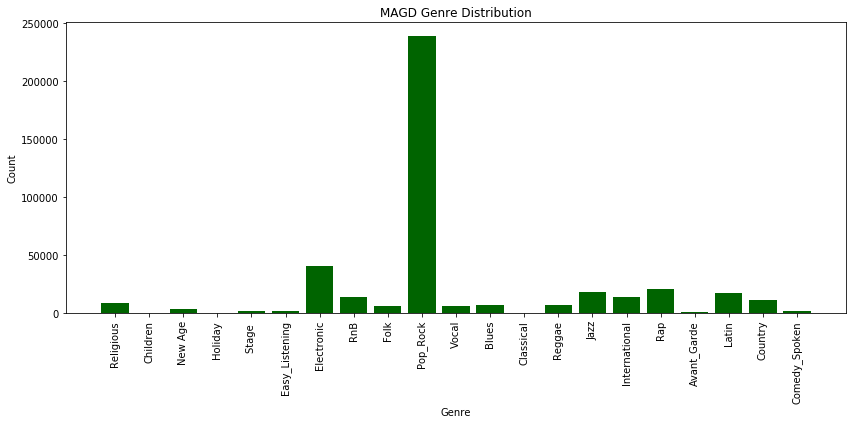

In [66]:
# counts for each genre
genre_counts = genreAssignment_df.groupBy("genre").count().toPandas()

# histgram
plt.figure(figsize=(12, 6))
plt.bar(genre_counts["genre"], genre_counts["count"], color='darkgreen')
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("MAGD Genre Distribution")
plt.xticks(rotation=90)  # rotation of xticks
plt.tight_layout()

In [51]:
data = data.withColumnRenamed("MSD_TRACKID", "track_id")
data = data.withColumn("track_id", regexp_replace("track_id", "^'|'$", ""))
data.show(20)

+----------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-----------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+------------------+--------------------+
|Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1|Spectral_Centroid_Overall_Average_1|Spectral_Flux_Overall_Average_1|Compactness_Overall_Average_1|Spectral_Variability_Overall_Average_1|Root_Mean_Square_Overall_

In [52]:
genre_feature_df = data.join(genreAssignment_df, on="track_id", how="inner")
genre_feature_df.show(20, truncate = False)

+------------------+----------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-----------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+---------------------------------------------------------------------------------------------+-------------+
|track_id          |Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1|Spectral_Centroid_Overall_Average_1|Spectral_Flux_Overal

In [37]:
row_count = genre_feature_df.count()
print(f"Total count of rows is {row_count}")
unique_track_count = genre_feature_df.select("track_id").distinct().count()
print("Number of unique track_id: ", unique_track_count)

Total count of rows is 420616
Number of unique track_id:  420616


### Binary classification "Electronic or not "

In [53]:
data = genre_feature_df.withColumn("label", when(col("genre") == "Electronic", 1).otherwise(0))
data.show(20)

+------------------+----------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-----------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+--------------------+-------------+-----+
|          track_id|Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1|Spectral_Centroid_Overall_Average_1|Spectral_Flux_Overall_Average_1|Compactness_Overall_Average_1|Spectral_Variability_Over

In [54]:
# cache the dataframe 

data.cache()

# Count rows
print(f'# rows = {data.count()}')

# rows = 420616


In [44]:
# Compute class frequency

show_as_html(data.groupby('label').count())

,label,count
0,0,379951
1,1,40665


### Stratification sampling 

In [55]:
# Exact stratification using Window (binary, counts hard coded)

temp = (
    data
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

training = temp.where(
    ((F.col("label") == 0) & (F.col("row") < 379670 * 0.8)) |  # nP_actual = 379670
    ((F.col("label") == 1) & (F.col("row") < 40688  * 0.8))    # nN_actual = 40688
)
training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(data, "data")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: data
total:   420616
counts:
   label   count    ratio
0      0  379951  0.90332
1      1   40665  0.09668

dataset: training
total:   336285
counts:
   label   count     ratio
0      0  303735  0.903207
1      1   32550  0.096793

dataset: test
total:   84331
counts:
   label  count     ratio
0      0  76216  0.903772
1      1   8115  0.096228



In [56]:
# Ensure datasets are cached
data.cache()
training.cache()
test.cache()

DataFrame[track_id: string, Spectral_Centroid_Overall_Standard_Deviation_1: double, Spectral_Flux_Overall_Standard_Deviation_1: double, Compactness_Overall_Standard_Deviation_1: double, Spectral_Variability_Overall_Standard_Deviation_1: double, Root_Mean_Square_Overall_Standard_Deviation_1: double, Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1: double, Spectral_Centroid_Overall_Average_1: double, Spectral_Flux_Overall_Average_1: double, Compactness_Overall_Average_1: double, Spectral_Variability_Overall_Average_1: double, Root_Mean_Square_Overall_Average_1: double, Fraction_Of_Low_Energy_Windows_Overall_Average_1: double, features: vector, genre: string, label: int]

In [57]:
# Downsampling on label 0

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where(
        ((F.col("label") == 1)) |
        ((F.col("label") == 0) & (F.col("random") < (60000 / 303735)))
    )
)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")


dataset: training (downsampled)
total:   92336
counts:
   label  count     ratio
0      0  59786  0.647483
1      1  32550  0.352517



In [58]:
# Upsampling on Label 1

counts = {label: count for label, count in training.groupBy("label").count().collect()}
count_lower_bound = 10000
count_upper_bound = 150000

def random_resample(x, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if np.random.rand() < count_upper_bound / count: # randomly downsample to count_upper_bound
            return [x]
        else:
            return []

    return [x]  # do nothing

random_resample_udf = F.udf(lambda x: random_resample(x, counts, count_lower_bound, count_upper_bound), ArrayType(IntegerType()))
training_upsampled = (
    training
    .withColumn("sample", random_resample_udf(F.col("label")))
    .select(
        F.col("track_id"),
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

#training_over.cache()
print_class_balance(training_upsampled, "training_upsampled")

dataset: training_upsampled
total:   106807
counts:
   label  count     ratio
0      0  74257  0.695245
1      1  32550  0.304755



In [59]:
# Set Weight of the label 1 class as 10, and set  weight of label 0 as 1

training_weighted = training.withColumn("weight", F.when(F.col("label") == 0, 1).when(F.col("label") == 1, 10.0).otherwise(1.0))

weights = (
    training_weighted
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)

   label weights
0      0   [1.0]
1      1  [10.0]


### Method 1:  Logistical regression for binary classification

### No resampling

In [60]:
# logistic regression
lr = LogisticRegression(featuresCol='features', labelCol='label')

lr_model = lr.fit(training)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        2143
nN:        82188

TP         1179
FP         964
FN         6936
TN         75252

precision: 0.55016332
recall:    0.14528651
accuracy:  0.90632152

auroc:     0.80799262



### downsampling 

In [61]:
# logistic regression with downsampled training data
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_downsampled)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        11578
nN:        72753

TP         4264
FP         7314
FN         3851
TN         68902

precision: 0.36828468
recall:    0.52544670
accuracy:  0.86760503

auroc:     0.81125112



### upsampling

In [62]:
# logistic regression with upsampled training data
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_upsampled)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        9590
nN:        74741

TP         3754
FP         5836
FN         4361
TN         70380

precision: 0.39144943
recall:    0.46260012
accuracy:  0.87908361

auroc:     0.81025349



### Observation Weight

In [64]:
# logistic regression with weighted training data
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_weighted)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        2143
nN:        82188

TP         1179
FP         964
FN         6936
TN         75252

precision: 0.55016332
recall:    0.14528651
accuracy:  0.90632152

auroc:     0.80799100



### Method 2: Random forest

### No resampling

In [65]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

rf_model = rf.fit(training)
pred = rf_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        378
nN:        83953

TP         278
FP         100
FN         7837
TN         76116

precision: 0.73544974
recall:    0.03425755
accuracy:  0.90588277

auroc:     0.74067883



### downsampling

In [66]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

rf_model = rf.fit(training_downsampled)
pred = rf_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        12420
nN:        71911

TP         3958
FP         8462
FN         4157
TN         67754

precision: 0.31867955
recall:    0.48773876
accuracy:  0.85036345

auroc:     0.78703219



### upsampling

In [67]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

rf_model = rf.fit(training_upsampled)
pred = rf_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        10481
nN:        73850

TP         3546
FP         6935
FN         4569
TN         69281

precision: 0.33832650
recall:    0.43696858
accuracy:  0.86358516

auroc:     0.78529737



### Observation Weight

In [69]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

rf_model = rf.fit(training_weighted)
pred = rf_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        378
nN:        83953

TP         278
FP         100
FN         7837
TN         76116

precision: 0.73544974
recall:    0.03425755
accuracy:  0.90588277

auroc:     0.74216213



### Method 3: SVM 

### No resampling

In [70]:
svm = LinearSVC(featuresCol='features', labelCol='label')

svm_model = svm.fit(training)

svm_pred = svm_model.transform(test)

svm_pred.cache()

print_metrics(svm_pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        0
nN:        84331

TP         0
FP         0
FN         8115
TN         76216

precision: 0.00000000
recall:    0.00000000
accuracy:  0.90377204

auroc:     0.71014560



### downsampling

In [71]:
svm = LinearSVC(featuresCol='features', labelCol='label')

svm_model = svm.fit(training_downsampled)

svm_pred = svm_model.transform(test)

svm_pred.cache()

print_metrics(svm_pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        10507
nN:        73824

TP         3466
FP         7041
FN         4649
TN         69175

precision: 0.32987532
recall:    0.42711029
accuracy:  0.86137956

auroc:     0.76327713



### upsampling

In [72]:
svm = LinearSVC(featuresCol='features', labelCol='label')

svm_model = svm.fit(training_upsampled)

svm_pred = svm_model.transform(test)

svm_pred.cache()

print_metrics(svm_pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        6621
nN:        77710

TP         2420
FP         4201
FN         5695
TN         72015

precision: 0.36550370
recall:    0.29821319
accuracy:  0.88265288

auroc:     0.75643360



### observation weight

In [73]:
svm = LinearSVC(featuresCol='features', labelCol='label')

svm_model = svm.fit(training_weighted)

svm_pred = svm_model.transform(test)

svm_pred.cache()

print_metrics(svm_pred)

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        0
nN:        84331

TP         0
FP         0
FN         8115
TN         76216

precision: 0.00000000
recall:    0.00000000
accuracy:  0.90377204

auroc:     0.71014095



### hyperparamter tuning in Logstic Regression

In [84]:
# Cross validation and hyperparameter tuning (Logistic Regression)

param_grid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.0, 0.1, 0.2])
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2])
    .build()
)
cross_validator = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC'),
    numFolds=3,
)
cross_validator_model = cross_validator.fit(training_downsampled)
pred = cross_validator_model.transform(test)
pred.cache()

print(f'hyperparameters selected')
print(f'')
print(f'regParam:        {cross_validator_model.bestModel.getRegParam()}')
print(f'elasticNetParam: {cross_validator_model.bestModel.getElasticNetParam()}')
print(f'')
print_metrics(pred)

hyperparameters selected

regParam:        0.0
elasticNetParam: 0.2

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        11602
nN:        72729

TP         4235
FP         7367
FN         3880
TN         68849

precision: 0.36502327
recall:    0.52187307
accuracy:  0.86663267

auroc:     0.80825129



### hyperparamter tuning in Random Forest

In [157]:
param_grid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [5, 10, 20])
    .addGrid(rf.numTrees, [20, 50, 100])
    .build()
)


cross_validator = CrossValidator(estimator = rf,
                                 estimatorParamMaps = param_grid,
                                 evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC'),
                                 numFolds = 3)


cross_validator_model = cross_validator.fit(training_downsampled)
pred = cross_validator_model.transform(test)
pred.cache()


print("Hyperparameters selected:")
print(f"Max Depth: {cross_validator_model.bestModel.getMaxDepth()}")
print(f"Number of Trees: {cross_validator_model.bestModel.getNumTrees}")
print("")

print_metrics(pred)

Hyperparameters selected:
Max Depth: 20
Number of Trees: 100

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        14512
nN:        69819

TP         5042
FP         9470
FN         3073
TN         66746

precision: 0.34743660
recall:    0.62131855
accuracy:  0.85126466

auroc:     0.84482602



### hyperparamter tuning in SVM

In [158]:
param_grid = (
    ParamGridBuilder() 
    .addGrid(svm.maxIter, [10, 20, 50]) 
    .addGrid(svm.regParam, [0.1, 0.05, 0.01]) 
    .build()
)
    

cross_validator = CrossValidator(estimator = svm,
                                 estimatorParamMaps = param_grid,
                                 evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC'),
                                 numFolds = 3 )

cross_validator_model = cross_validator.fit(training_downsampled)

pred = cross_validator_model.transform(test)
pred.cache()

print("Hyperparameters selected:")
print(f"Max Iterations: {cross_validator_model.bestModel.getMaxIter()}")
print(f"Regularization Parameter: {cross_validator_model.bestModel.getRegParam()}")
print("")

print_metrics(pred)

Hyperparameters selected:
Max Iterations: 50
Regularization Parameter: 0.05

metrics for custom threshold

threshold: 0.5

total:     84331

nP actual: 8115
nN actual: 76216

nP:        7870
nN:        76461

TP         2716
FP         5154
FN         5399
TN         71062

precision: 0.34510801
recall:    0.33468885
accuracy:  0.87486215

auroc:     0.74091757



### Multi-class prediction
Method Decision: logistic regression

In [74]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [75]:
# generate genre labels

string_indexer = StringIndexer(inputCol="genre", outputCol="label")
model = string_indexer.fit(genre_feature_df)
data = model.transform(genre_feature_df)
data = data.withColumn("label", col("label").cast("integer"))

In [76]:
data.show(20, truncate = False)

+------------------+----------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-----------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+---------------------------------------------------------------------------------------------+-------------+-----+
|track_id          |Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1|Spectral_Centroid_Overall_Average_1|Spectral_Flux_

In [77]:
# cache the dataframe 

data.cache()

# Count rows
print(f'# rows = {data.count()}')

# rows = 420616


In [78]:
# Compute class frequency

show_as_html(data.groupby('label').count(), n = 30)

,label,count
0,14,2067
1,13,4000
2,11,6182
3,7,11689
4,0,237649
5,8,8780
6,5,14314
7,2,20899
8,17,1012
9,15,1613


### stratification sampling on multi-class

In [79]:
# Exact stratification using Window (multi-class, counts computed on the fly)

temp = (
    data
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    data
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

print(counts)

training = temp
for label in labels:
    training = training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(data, "data")
print_class_balance(training, "training")
print_class_balance(test, "test")

{14: 2067, 13: 4000, 11: 6182, 7: 11689, 0: 237649, 8: 8780, 5: 14314, 2: 20899, 17: 1012, 15: 1613, 19: 463, 12: 5789, 18: 555, 10: 6801, 1: 40665, 3: 17774, 20: 200, 9: 6931, 6: 14194, 16: 1535, 4: 17504}
dataset: data
total:   420616
counts:
    label   count     ratio
0      14    2067  0.004914
1      13    4000  0.009510
2      11    6182  0.014697
3       7   11689  0.027790
4       0  237649  0.565002
5       8    8780  0.020874
6       5   14314  0.034031
7       2   20899  0.049687
8      17    1012  0.002406
9      15    1613  0.003835
10     19     463  0.001101
11     12    5789  0.013763
12     18     555  0.001319
13     10    6801  0.016169
14      1   40665  0.096680
15      3   17774  0.042257
16     20     200  0.000475
17      9    6931  0.016478
18      6   14194  0.033746
19     16    1535  0.003649
20      4   17504  0.041615

dataset: training
total:   336481
counts:
    label   count     ratio
0      13    3199  0.009507
1      14    1653  0.004913
2       7   

In [82]:
# Ensure datasets are cached

data.cache()
training.cache()
test.cache()

DataFrame[track_id: string, Spectral_Centroid_Overall_Standard_Deviation_1: double, Spectral_Flux_Overall_Standard_Deviation_1: double, Compactness_Overall_Standard_Deviation_1: double, Spectral_Variability_Overall_Standard_Deviation_1: double, Root_Mean_Square_Overall_Standard_Deviation_1: double, Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1: double, Spectral_Centroid_Overall_Average_1: double, Spectral_Flux_Overall_Average_1: double, Compactness_Overall_Average_1: double, Spectral_Variability_Overall_Average_1: double, Root_Mean_Square_Overall_Average_1: double, Fraction_Of_Low_Energy_Windows_Overall_Average_1: double, features: vector, genre: string, label: int]

### reweighting

In [145]:
# Observation reweighting

training_weighted = training.withColumn(
    "weight",
    F.when(F.col("label").isin(18, 19, 20), 100.0)
    .when(F.col("label").isin(0), 1.0)
    .otherwise(50.0)
)

weights = (
    training_weighted
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)

print_class_balance(training_weighted, "training (weighted)")


    label  weights
0      13   [50.0]
1      14   [50.0]
2       7   [50.0]
3      11   [50.0]
4       0    [1.0]
5       8   [50.0]
6       5   [50.0]
7       2   [50.0]
8      17   [50.0]
9      15   [50.0]
10     19  [100.0]
11     12   [50.0]
12     18  [100.0]
13     10   [50.0]
14      1   [50.0]
15      3   [50.0]
16     20  [100.0]
17      6   [50.0]
18      9   [50.0]
19     16   [50.0]
20      4   [50.0]
dataset: training (weighted)
total:   336481
counts:
    label   count     ratio
0      13    3199  0.009507
1      14    1653  0.004913
2       7    9351  0.027791
3      11    4945  0.014696
4       0  190119  0.565022
5       8    7023  0.020872
6       5   11451  0.034032
7       2   16719  0.049688
8      17     809  0.002404
9      15    1290  0.003834
10     19     370  0.001100
11     12    4631  0.013763
12     18     443  0.001317
13     10    5440  0.016167
14      1   32531  0.096680
15      3   14219  0.042258
16     20     159  0.000473
17      6   11355  0.0337

In [85]:
from pyspark.ml.classification import OneVsRest

# mutli-class regression

mlr = LogisticRegression(featuresCol='features', labelCol='label',maxIter=20,  elasticNetParam=0, fitIntercept=True)

ovr = OneVsRest(classifier=mlr)
ovrModel = ovr.fit(training)
predictions = ovrModel.transform(test)

# evaluation.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {accuracy}" )

Accuracy = 0.5798181494027456


### Song recommendations

In [86]:
# repartition the triplets_df

data = triplets_df.repartition(partitions)

data.cache()

data.printSchema()

show_as_html(data)

root
 |-- song_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- count: string (nullable = true)



,song_id,user_id,count
0,SOJAKGH12A6BD4F6BE,7200115825f3983929cb3dd1cd73374f673e0f6c,1
1,SOCFLEV12A8C1398D6,1c2f73daf456e34733ccf9cb4265b04c9a20b717,1
2,SOINADV12AF72A54C3,e1b8ffb7889cafbbeb12c51841cc5328cad9ef90,6
3,SOYGQGR12AF72ABAB8,c116b60ddfbc2214d3f0d481ebca4eab867e5069,2
4,SOSJRXV12A8C136E1B,f04b2559b47609dd2ff8cf9d2fe7c95092046940,11
5,SOMEOXI12AB0189D21,53f1230e5eaf89cc820855ffecfd20c256d35346,5
6,SOSTGAF12A58A7B18B,753e85360138042ee7b92732e9d0d9b878e83027,2
7,SOGANPB12AB017C4C8,79bd8200456a29f9948cc5917b27914e26d37d75,3
8,SOAYETG12A67ADA751,62e5710f2a153022c8781e83fdf6251c402154c3,2
9,SOLMEOE12A6D4F7986,1179d1b94432ece88757446452f9b6e2745a1124,1


In [87]:
# count the unique songs
unique_songs_count = data.select("song_id").distinct().count()

print("Number of unique songs:", unique_songs_count)


Number of unique songs: 378310


In [88]:
# count the unique user
unique_users_count = data.select("user_id").distinct().count()

print("Number of unique users:", unique_users_count)

Number of unique users: 1019318


In [89]:
# make sure the count is int type

data = data.withColumn("count", col("count").cast("int"))
data.show()

+------------------+--------------------+-----+
|           song_id|             user_id|count|
+------------------+--------------------+-----+
|SOJAKGH12A6BD4F6BE|7200115825f398392...|    1|
|SOCFLEV12A8C1398D6|1c2f73daf456e3473...|    1|
|SOINADV12AF72A54C3|e1b8ffb7889cafbbe...|    6|
|SOYGQGR12AF72ABAB8|c116b60ddfbc2214d...|    2|
|SOSJRXV12A8C136E1B|f04b2559b47609dd2...|   11|
|SOMEOXI12AB0189D21|53f1230e5eaf89cc8...|    5|
|SOSTGAF12A58A7B18B|753e85360138042ee...|    2|
|SOGANPB12AB017C4C8|79bd8200456a29f99...|    3|
|SOAYETG12A67ADA751|62e5710f2a153022c...|    2|
|SOLMEOE12A6D4F7986|1179d1b94432ece88...|    1|
|SOXLTRZ12AB0186A92|af2c6b7b356333b44...|    2|
|SOADQPP12A67020C82|8eff21b262514fadd...|    1|
|SOXROCS12AB018A202|2dc8264cf6cfbd09e...|    2|
|SOIOZHO12AB017FE5E|6fb15c14de2a0211b...|    3|
|SOOANTI12A6D4FBC90|0394088dd86f4de2f...|    1|
|SOYTAIJ12A8C1351A8|f20250e5cc1d1f8b5...|    1|
|SOYRUSS12A6D4F941D|11c25cffeac754195...|    2|
|SOMTBXX12AF729F5A6|900254d458c84ccf1...

In [90]:
# find the unique songs played by most active user

most_active_user = data.groupBy("user_id").sum("count").orderBy(col("sum(count)").desc()).first()["user_id"]

unique_songs = data.filter(col("user_id") == most_active_user).select("song_id").distinct().count()

print("Number of different songs played by the most active user:", unique_songs)

Number of different songs played by the most active user: 195


In [94]:
# percentage calculation 

unique_song_percentage = (unique_songs / unique_songs_count) * 100

print(f"Percentage of unique total songs : {unique_song_percentage:.3f}%")

Percentage of unique total songs : 0.052%


### Visualize the distribution

In [95]:
# count the play times for each song

song_play_counts = data.groupBy("song_id").sum("count").withColumnRenamed("sum(count)", "play_count").toPandas()

# count the play times for each user
user_play_counts = data.groupBy("user_id").sum("count").withColumnRenamed("sum(count)", "play_count").toPandas()


In [96]:
statistics = song_play_counts["play_count"].describe()

print(statistics)

count    378310.000000
mean        347.103851
std        2978.605349
min           1.000000
25%           8.000000
50%          31.000000
75%         130.000000
max      726885.000000
Name: play_count, dtype: float64


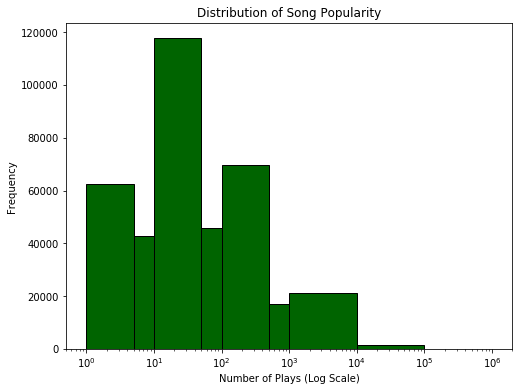

In [97]:
# distribution of song play times
plt.figure(figsize=(8, 6))

bins = [1, 5, 10, 50, 100, 500, 1000, 10000, 100000, 1000000] 

plt.hist(song_play_counts["play_count"], bins=bins, color='darkgreen', edgecolor='black')
plt.xscale('log') 
plt.title("Distribution of Song Popularity")
plt.xlabel("Number of Plays (Log Scale)")
plt.ylabel("Frequency")
plt.show()


In [98]:
statistics = user_play_counts["play_count"].describe()

print(statistics)

count    1.019318e+06
mean     1.288242e+02
std      1.754396e+02
min      3.000000e+00
25%      3.200000e+01
50%      6.900000e+01
75%      1.550000e+02
max      1.307400e+04
Name: play_count, dtype: float64


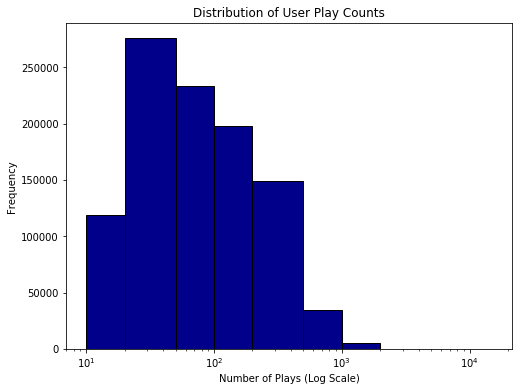

In [99]:
plt.figure(figsize=(8, 6))

bins = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 15000]  

plt.hist(user_play_counts["play_count"], bins=bins, color='darkblue', edgecolor='black')
plt.xscale('log') 
plt.title("Distribution of User Play Counts")
plt.xlabel("Number of Plays (Log Scale)")
plt.ylabel("Frequency")
plt.show()

In [100]:
# Find the songs which is played >= N times
N = 5

song_play_counts = data.groupBy("song_id").agg(F.sum("count").alias("play_count"))

valid_songs = song_play_counts.filter(song_play_counts.play_count >= N).select("song_id").rdd.flatMap(lambda x: x).collect()

In [101]:
# Find the users which is played >= M times of songs
M = 30

user_song_counts = data.groupBy("user_id").agg(F.countDistinct("song_id").alias("song_count"))

valid_users = user_song_counts.filter(user_song_counts.song_count >= M).select("user_id").rdd.flatMap(lambda x: x).collect()

In [102]:
valid_songs_df = spark.createDataFrame([(song_id,) for song_id in valid_songs], ["song_id"])
valid_users_df = spark.createDataFrame([(user_id,) for user_id in valid_users], ["user_id"])

recommendation_df = data.join(valid_songs_df, "song_id", "inner").join(valid_users_df, "user_id", "inner")

In [96]:
recommendation_df.show(50, truncate = False)

+----------------------------------------+------------------+-----+
|user_id                                 |song_id           |count|
+----------------------------------------+------------------+-----+
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOISKOP12A6310E2B5|14   |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOBNZTU12AB0188907|9    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOXGMFD12A8C132B83|5    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOPWVUB12A8C1386EE|1    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOPJLOZ12A8C132642|1    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SODKKNZ12A8C13E383|9    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOOYIHH12AB018C2C7|1    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOOHRZZ12A8C1334B8|5    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOOBMLO12A8C13B7B6|5    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SONQCMY12A6D4FB810|3    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOVIEIL12A6D4F7D84|1    |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOXLOQ

In [103]:
# count the rows

row_counts = recommendation_df.count()

print(row_counts)

36186108


In [104]:
data = recommendation_df
data = data.withColumn("count", col("count").cast("int"))
data.cache()

DataFrame[user_id: string, song_id: string, count: int]

In [105]:
# Simple random splitting

training, test = data.randomSplit([0.75, 0.25], seed = 123)    # without caching below, randomSplit is rerun every time you do something

training.cache()
test.cache()

show_as_html(training)
show_as_html(test)

,user_id,song_id,count
0,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOBKRRI12A8C135DC5,5
1,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOBNZTU12AB0188907,9
2,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOBYXSO12AB0180014,5
3,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOCDTEX12AB017CA4D,1
4,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SODKKNZ12A8C13E383,9
5,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOGEJKA12A58A7D3A8,15
6,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOGNXXS12AB0184504,1
7,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOHCWEJ12A8C13EBD9,1
8,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOHZPYD12AF72A12E2,1
9,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOIHGCE12A8C134A3E,5


,user_id,song_id,count
0,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOBPHXV12A6D4F9FD0,6
1,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOEZFIG12AF729D52E,3
2,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOISKOP12A6310E2B5,14
3,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOIYQUA12A8AE46860,5
4,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SONQCMY12A6D4FB810,3
5,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOPJLOZ12A8C132642,1
6,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOVMWUC12A8C13750B,3
7,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOXGMFD12A8C132B83,5
8,0008320d84f011147fb4eb6afce9e4124ed8b7d5,SOZLLTY12A8C132D24,1
9,000f295d2b9ddd4ed0bfe674f010dbc4376270f7,SOANPSM12A6D4FAB4C,1


In [106]:
# find users of training dataset
training_users = set(training.select(col("user_id")).distinct().rdd.flatMap(lambda x: x).collect())

# find the users of test dataset
test_users = set(test.select(col("user_id")).distinct().rdd.flatMap(lambda x: x).collect())


In [107]:
# common users in training and test 
common_users = training_users.intersection(test_users)

# find the users only in training but not in test set
users_training_only = list(training_users - common_users)

# find the users only in test but no in training set
users_test_only = list(test_users - common_users)

In [108]:
print (len(users_training_only))
print (len(users_test_only))

7
0


In [109]:
# Count rows

print(f'# training rows = {training.count()}')
print(f'# test rows     = {test.count()}')

# training rows = 27137240
# test rows     = 9048868


### Training the ALS Model

In [110]:
from pyspark.ml.feature import StringIndexer

user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
song_indexer = StringIndexer(inputCol="song_id", outputCol="song_index")

# transfrom in training dataset
training = user_indexer.fit(training).transform(training)
training = song_indexer.fit(training).transform(training)


# transfrom in test dataset
test = user_indexer.fit(test).transform(test)
test = song_indexer.fit(test).transform(test)

In [111]:
# make sure the index type is int
training = training.withColumn("user_index", col("user_index").cast("int"))
training = training.withColumn("song_index", col("song_index").cast("int"))

test = test.withColumn("user_index", col("user_index").cast("int"))
test = test.withColumn("song_index", col("song_index").cast("int"))

In [112]:
training.show(20, truncate = False)

+----------------------------------------+------------------+-----+----------+----------+
|user_id                                 |song_id           |count|user_index|song_index|
+----------------------------------------+------------------+-----+----------+----------+
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOBKRRI12A8C135DC5|5    |398508    |62174     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOBNZTU12AB0188907|9    |398508    |33493     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOBYXSO12AB0180014|5    |398508    |80783     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOCDTEX12AB017CA4D|1    |398508    |29525     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SODKKNZ12A8C13E383|9    |398508    |2413      |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOGEJKA12A58A7D3A8|15   |398508    |46586     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOGNXXS12AB0184504|1    |398508    |16541     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOHCWEJ12A8C13EBD9|1    |398508    |8745      |
|0008320d8

In [109]:
test.show(20, truncate = False)

+----------------------------------------+------------------+-----+----------+----------+
|user_id                                 |song_id           |count|user_index|song_index|
+----------------------------------------+------------------+-----+----------+----------+
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOBKRRI12A8C135DC5|5    |400130    |64249     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOBNZTU12AB0188907|9    |400130    |35725     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOCDTEX12AB017CA4D|1    |400130    |32676     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SODKKNZ12A8C13E383|9    |400130    |2796      |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOGEJKA12A58A7D3A8|15   |400130    |42730     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOPJLOZ12A8C132642|1    |400130    |6383      |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOTLFEU12AB01885DB|4    |400130    |30951     |
|0008320d84f011147fb4eb6afce9e4124ed8b7d5|SOVIEIL12A6D4F7D84|1    |400130    |6817      |
|000f295d2

In [113]:
# Training

als = ALS(maxIter= 10, regParam=0.05, userCol="user_index", itemCol="song_index", ratingCol="count", implicitPrefs=True)

alsModel = als.fit(training)

In [114]:
# Predict relevance scores

pred = alsModel.transform(test)
pred.cache()

pred.printSchema()
show_as_html(pred)

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- user_index: integer (nullable = true)
 |-- song_index: integer (nullable = true)
 |-- prediction: float (nullable = false)



,user_id,song_id,count,user_index,song_index,prediction
0,bf40f6ff247d419d07f720f0fc6af30caf0d99c2,SOTCMDJ12A6D4F8528,1,146,38,0.155448
1,38b4446f747464f951948ee3a84a1f83549ca07b,SOTCMDJ12A6D4F8528,11,1025,38,0.065676
2,2e4b43f8dd8c00ef43c7011df0d0989acd47b3ab,SOTCMDJ12A6D4F8528,1,1838,38,0.466973
3,135b8f915ae1a8849923ed77b3c568b842fcc3e3,SOTCMDJ12A6D4F8528,1,2160,38,0.030742
4,3f47c787130d4d34e50e489ffac61e01ff3755b7,SOTCMDJ12A6D4F8528,6,3934,38,-0.000547
5,c072e40a16b43ef18966c7a5088256c15d5bbc48,SOTCMDJ12A6D4F8528,1,4182,38,0.298080
6,22e5ed90a4357bec0460c8e4e44eb6d2ff518c9e,SOTCMDJ12A6D4F8528,28,6429,38,0.205654
7,da9c975bece3be2e9ddea3077a01be908758e266,SOTCMDJ12A6D4F8528,1,7443,38,0.183963
8,66aa46b28968cafb37734475d5c79fbc58733534,SOTCMDJ12A6D4F8528,1,9300,38,0.291657
9,00fa7bf954e7845230729c03484758606cb77797,SOTCMDJ12A6D4F8528,5,10406,38,0.086730


In [115]:
# Generate recommendations

k = 10

recommendations = alsModel.recommendForAllUsers(k)

recommendations.printSchema()
show_as_html(recommendations)

root
 |-- user_index: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- song_index: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



,user_index,recommendations
0,38,"[(57, 1.081993579864502), (106, 0.973300874233..."
1,273,"[(11, 0.9948319792747498), (7, 0.7566444873809..."
2,300,"[(57, 0.4090930223464966), (139, 0.38021045923..."
3,412,"[(0, 1.0671979188919067), (13, 1.0081214904785..."
4,434,"[(92, 0.524361252784729), (57, 0.5220175981521..."
5,475,"[(76, 1.0633217096328735), (37, 0.988428592681..."
6,585,"[(57, 0.7580752968788147), (126, 0.74219328165..."
7,600,"[(48, 0.28559187054634094), (0, 0.276427447795..."
8,611,"[(37, 0.7037515044212341), (184, 0.63747012615..."
9,619,"[(57, 0.5920076966285706), (219, 0.54713273048..."


In [121]:
recommendations.show(20, truncate = False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                                                                                                             |
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|38        |[{15, 0.7144719}, {8, 0.7053894}, {4, 0.66087234}, {20, 0.6547308}, {329, 0.6155827}, {60, 0.6071626}, {180, 0.5946536}, {70, 0.58190966}, {61, 0.5720096}, {248, 0.56409836}]              |
|273       |[{158, 0.47054303}, {80, 0.4143763}, {61, 0.41212857}, {145, 0.39318615}, {207, 0.3841133}, {185, 0.38338766}, {0, 0.38136375}, {109, 0.37565044}, {235, 0.36580083}, {24, 0.3633474

### Evaluation Metrix

In [116]:
# Collect and sort relevant items in order of descending relevance (e.g. rating)

relevant = (
    test
    .groupBy("user_index")  
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("count"),
                F.col("song_index"), 
            )
        ))).alias("relevant")
    )
)

In [117]:
# Merge recommendations and relevant items so they can be compared

temp = (
    recommendations
    .select(
        F.col("user_index"),
        F.col("recommendations.song_index").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_index"),
            F.col("relevant.song_index").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_index",
        how="inner"
    )
)
temp.cache()

temp.printSchema()


root
 |-- user_index: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



In [118]:
temp.show(20, truncate = False)

+----------+--------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [119]:
# Metrics

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.01191
MAP @ K:       0.00463
NDCG @ K:      0.01309



### The coding work in MSD project ends

In [126]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()